In [1]:
pip install wandb scipy seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import wandb
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.lines as mlines

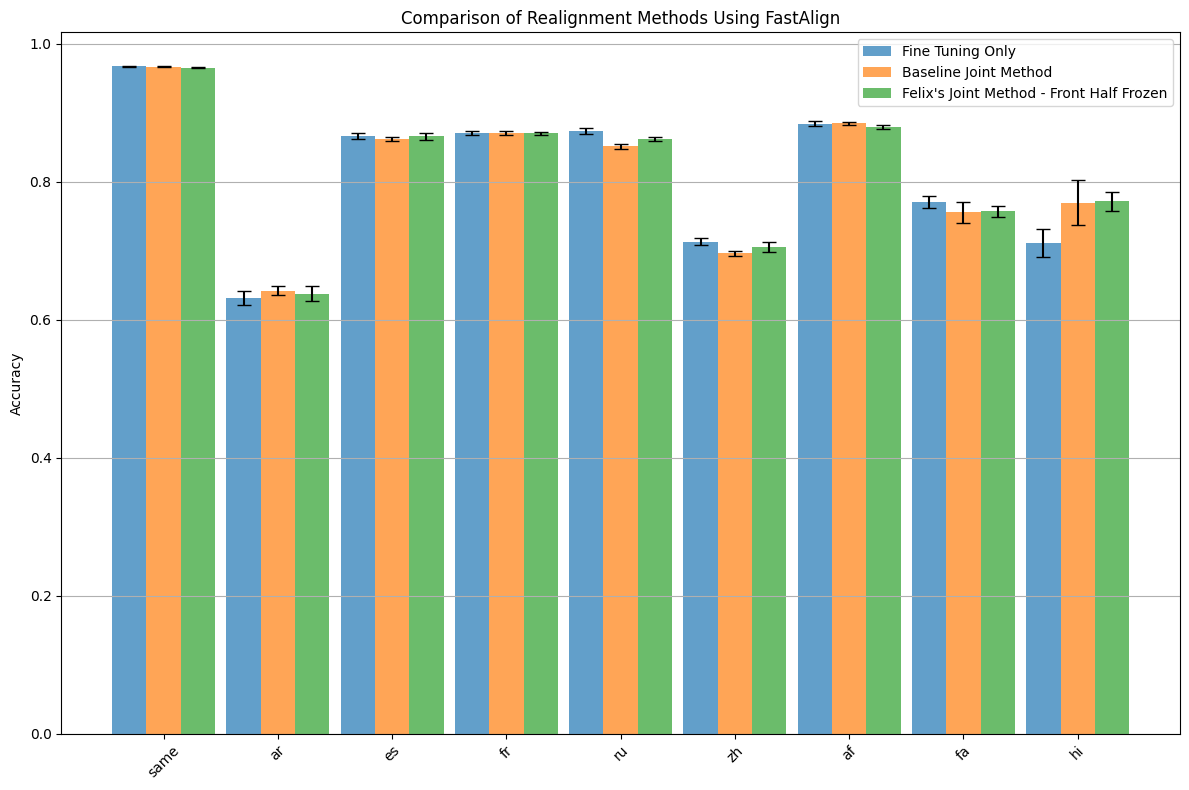

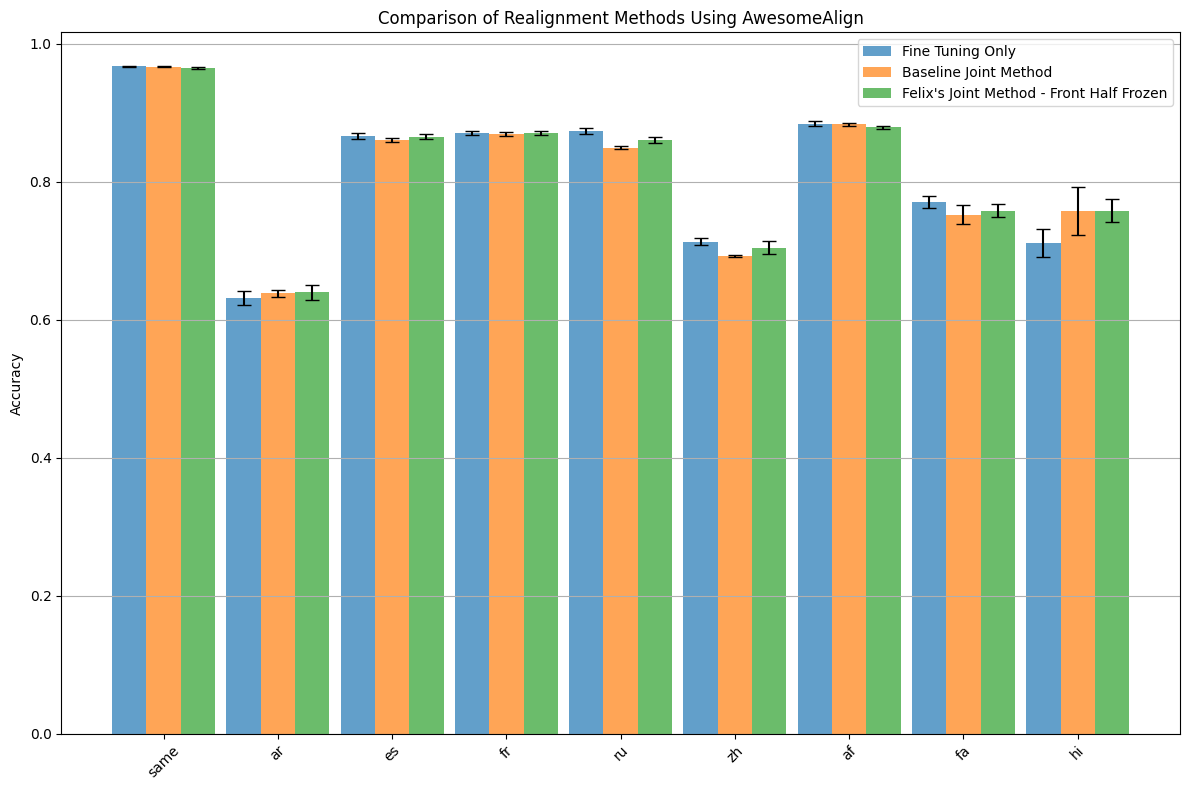

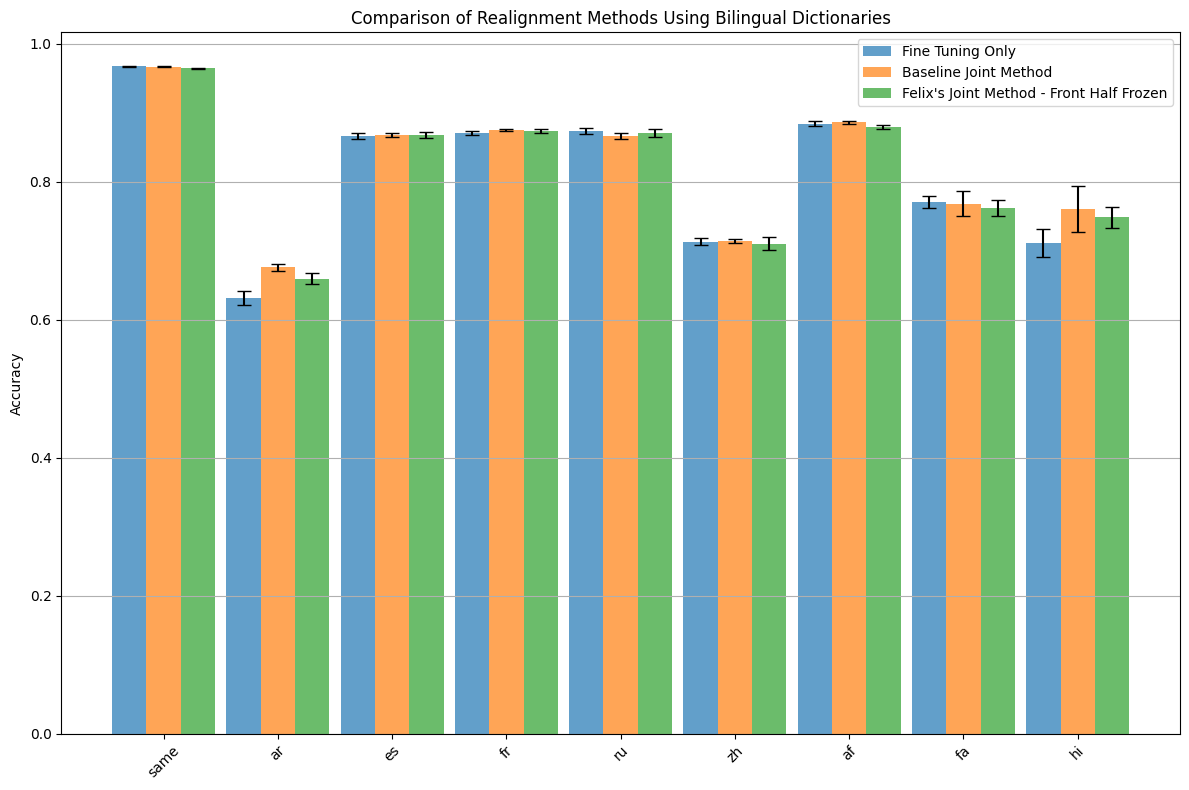

In [3]:

api = wandb.Api()


workspace = "align_freeze"


baseline_project_name = "3nl_baseline_udpos"


project_pairs = [
    ("3nl_during_fastalign_udpos", "3nl_during_partial_freeze_front_fastalign_udpos"),
    ("3nl_during_awesome_udpos", "3nl_during_partial_freeze_front_awesome_udpos"),
    ("3nl_during_dico_udpos", "3nl_during_partial_freeze_front_dico_udpos"),
]


langs = ["same", "ar", "es", "fr", "ru", "zh", "af", "fa", "hi"]


def fetch_and_process_runs(project, username="felixgaschi"):
    runs_data = {lang: [] for lang in langs}
    runs = api.runs(f"{workspace}/{project}")
    for run in runs:
        if run.user.username == username:  
            for lang in langs:
                accuracy_key = f"eval_{lang}_accuracy"
                accuracy = run.summary.get(accuracy_key)
                if accuracy is not None:
                    runs_data[lang].append(accuracy)

    assert all([len(runs) == 5 for language, runs in runs_data.items()])
    return runs_data


baseline_project_data = fetch_and_process_runs(baseline_project_name)


def plot_comparison(global_baseline_data, baseline_data, freezing_data, langs, global_baseline_name, baseline_name, freezing_name, global_baseline_title, baseline_title, new_method_title):
    width = 0.3  
    x = np.arange(len(langs))  

    fig, ax = plt.subplots(figsize=(12, 8))

    global_baseline_means = [np.mean(global_baseline_data[lang]) for lang in langs]
    global_baseline_cis = [scipy.stats.sem(global_baseline_data[lang]) * scipy.stats.t.ppf((1 + 0.95) / 2., len(global_baseline_data[lang])-1) if global_baseline_data[lang] else 0 for lang in langs]

    baseline_means = [np.mean(baseline_data[lang]) for lang in langs]
    baseline_cis = [scipy.stats.sem(baseline_data[lang]) * scipy.stats.t.ppf((1 + 0.95) / 2., len(baseline_data[lang])-1) if baseline_data[lang] else 0 for lang in langs]

    freezing_means = [np.mean(freezing_data[lang]) for lang in langs]
    freezing_cis = [scipy.stats.sem(freezing_data[lang]) * scipy.stats.t.ppf((1 + 0.95) / 2., len(freezing_data[lang])-1) if freezing_data[lang] else 0 for lang in langs]

    rects1 = ax.bar(x - width, global_baseline_means, width, yerr=global_baseline_cis, label=global_baseline_name, capsize=5, alpha=0.7, ecolor='black')
    rects2 = ax.bar(x, baseline_means, width, yerr=baseline_cis, label=baseline_name, capsize=5, alpha=0.7, ecolor='black')
    rects3 = ax.bar(x + width, freezing_means, width, yerr=freezing_cis, label=freezing_name, capsize=5, alpha=0.7, ecolor='black')

    ax.set_ylabel('Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(langs)
    aligner_name = baseline_name.split('_')[-2]
    if aligner_name == 'dico':
        aligner_name = 'Bilingual Dictionaries'
    elif aligner_name == 'awesome':
        aligner_name = 'AwesomeAlign'
    elif aligner_name == 'fastalign':
        aligner_name = 'FastAlign'
    ax.set_title(f"Comparison of Realignment Methods Using {aligner_name}")
    ax.legend([global_baseline_title, baseline_title, new_method_title])
    ax.yaxis.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


for baseline_project, freezing_project in project_pairs:
    baseline_data = fetch_and_process_runs(baseline_project)
    freezing_data = fetch_and_process_runs(freezing_project)

    
    plot_comparison(baseline_project_data, baseline_data, freezing_data, langs, 'Global Baseline', baseline_project, freezing_project, 'Fine Tuning Only', "Baseline Joint Method", "Felix's Joint Method - Front Half Frozen")

In [4]:

def plot_individual_violin_deltas_with_cis(project_pairs, langs, title=None):
    for baseline_project, align_freeze_project in project_pairs:
        
        baseline_data = fetch_and_process_runs(baseline_project)
        align_freeze_data = fetch_and_process_runs(align_freeze_project)

        
        delta_data = []

        
        for lang in langs:
            lang_deltas = [align_freeze - baseline for baseline, align_freeze in zip(baseline_data[lang], align_freeze_data[lang])]
            mean_delta = np.mean(lang_deltas)
            ci = scipy.stats.sem(lang_deltas) * scipy.stats.t.ppf((1 + 0.95) / 2., len(lang_deltas)-1)
            delta_data.extend([{'Language': lang, 'Delta': delta, 'Mean Delta': mean_delta, 'CI': ci} for delta in lang_deltas])

        
        df = pd.DataFrame(delta_data)

        
        plt.figure(figsize=(10, 6))
        ax = sns.violinplot(x='Language', y='Delta', data=df, inner='quartile', palette='coolwarm', dodge=False, hue='Language')
        ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])

        
        
        means = df.groupby('Language')['Delta'].mean().reindex(langs)
        cis = df.groupby('Language')['CI'].mean().reindex(langs)

        
        error_bars = plt.errorbar(range(len(langs)), means, yerr=cis, fmt='o', color='black', capsize=5, label='Mean Delta ± CI')

        aligner_name = baseline_project.split('_')[-2]
        if aligner_name == 'dico':
            aligner_name = 'Bilingual Dictionaries'
        elif aligner_name == 'awesome':
            aligner_name = 'AwesomeAlign'
        elif aligner_name == 'fastalign':
            aligner_name = 'FastAlign'

        if title:
            plt.title(f'{title} - {aligner_name}')

        else:
            plt.title(f'Delta Accuracy (Align-Freeze minus Baseline) for {aligner_name} - Front Half Frozen')
        plt.axhline(0, color='grey', linewidth=0.8)  
        plt.ylabel('Delta Accuracy')

        
        quartiles_median_line = mlines.Line2D([], [], color='black', linestyle='--', label='Quartiles/Median')
        mean_delta_ci_line = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='Mean Delta ± CI')

        
        ax.legend(handles=[quartiles_median_line, mean_delta_ci_line], loc='lower right', title="Legend")

        plt.tight_layout()
        plt.show()

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


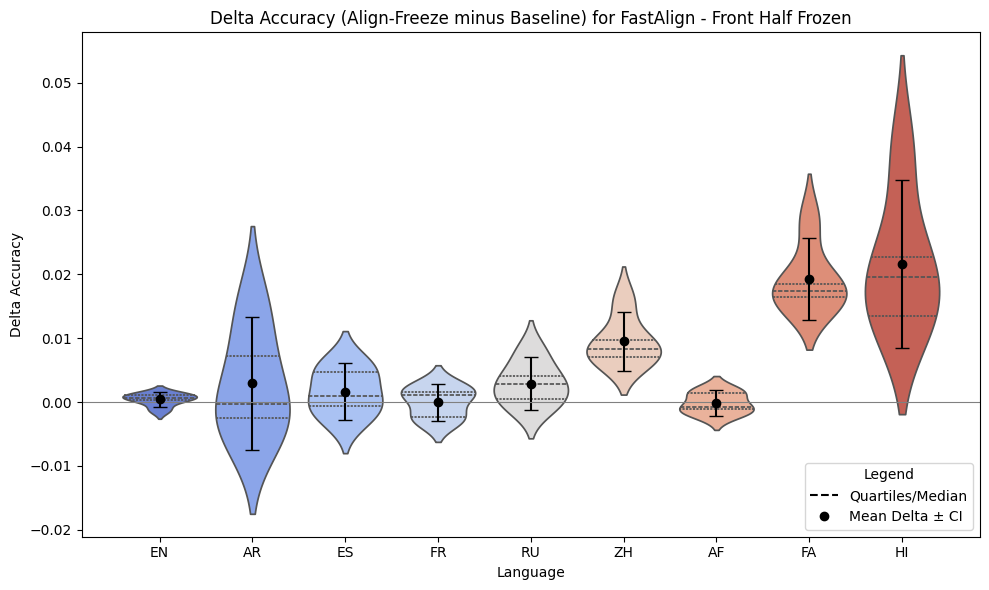

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


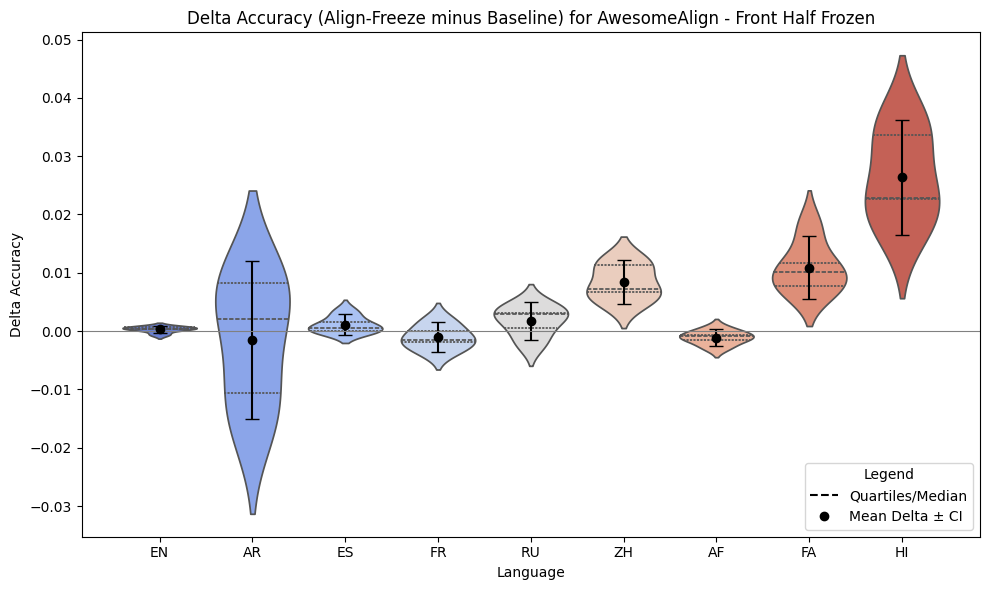

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


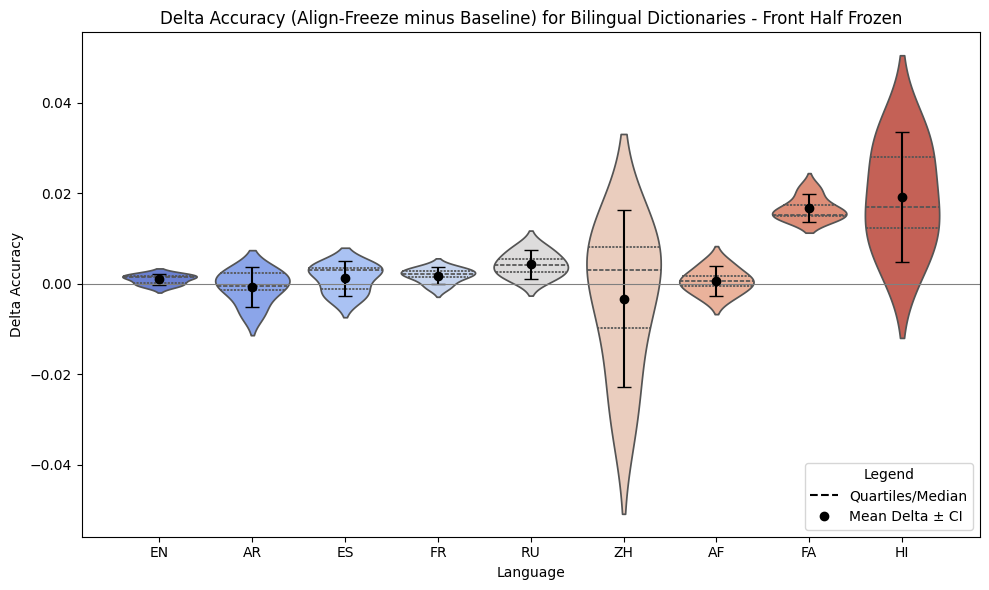

In [5]:
project_pairs = [
    ("3nl_before_fastalign_udpos", "3nl_freeze_realign_unfreeze_fastalign_udpos"),
    ("3nl_before_awesome_udpos", "3nl_freeze_realign_unfreeze_awesome_udpos"),
    ("3nl_before_dico_udpos", "3nl_freeze_realign_unfreeze_dico_udpos"),
]

plot_individual_violin_deltas_with_cis(project_pairs, langs)

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


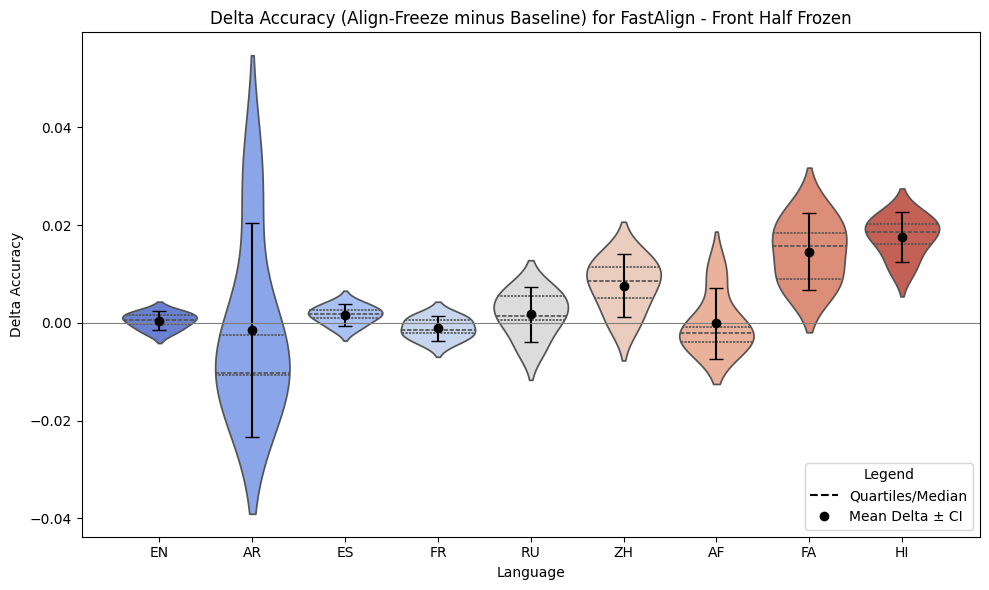

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


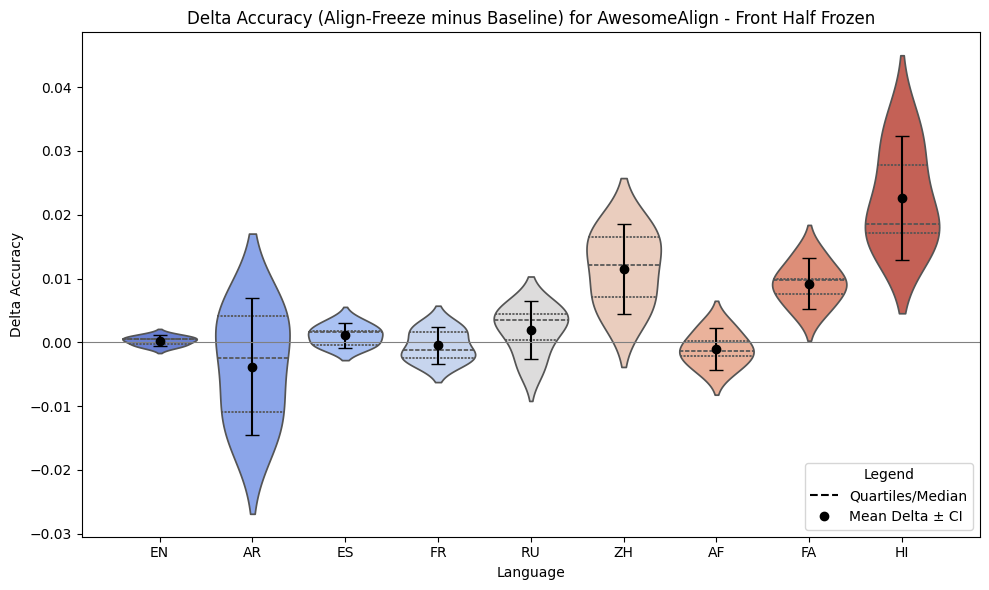

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


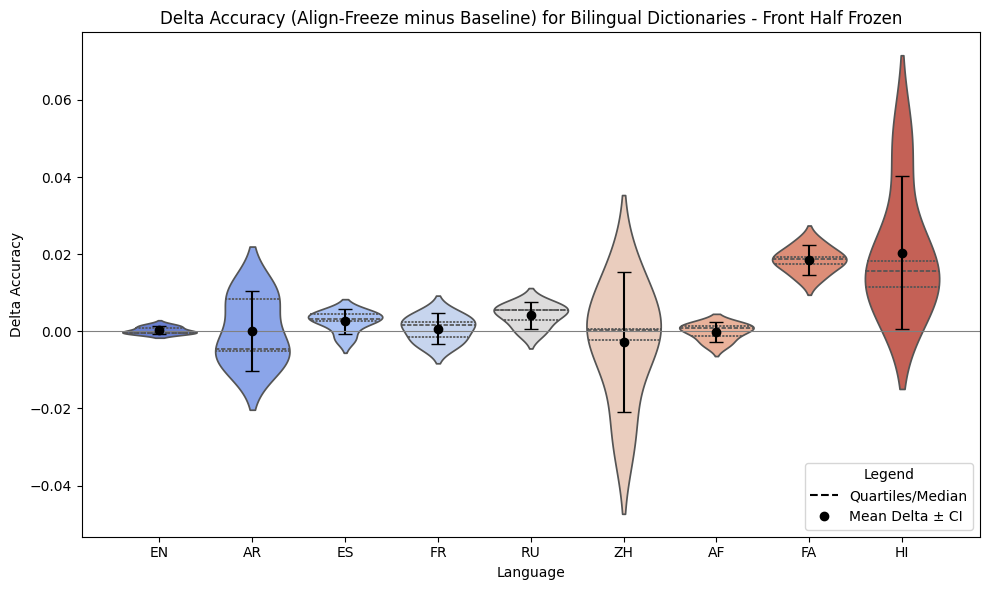

In [6]:
project_pairs = [
    ("3nl_filtered_0.5_before_fastalign_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_fastalign_udpos"),
    ("3nl_filtered_0.5_before_awesome_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_awesome_udpos"),
    ("3nl_filtered_0.5_before_dico_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_dico_udpos"),
]
plot_individual_violin_deltas_with_cis(project_pairs, langs)

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


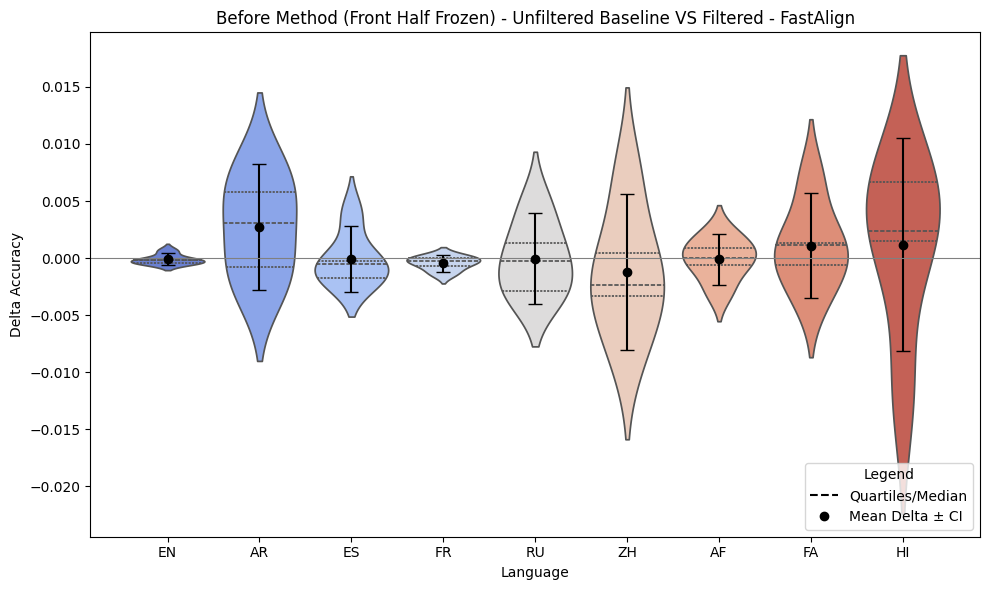

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


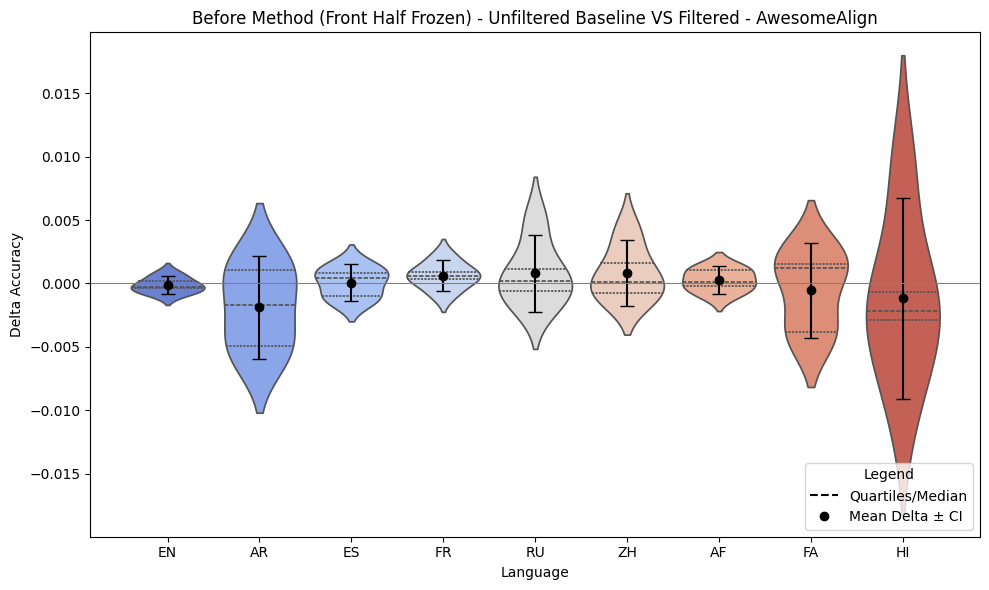

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


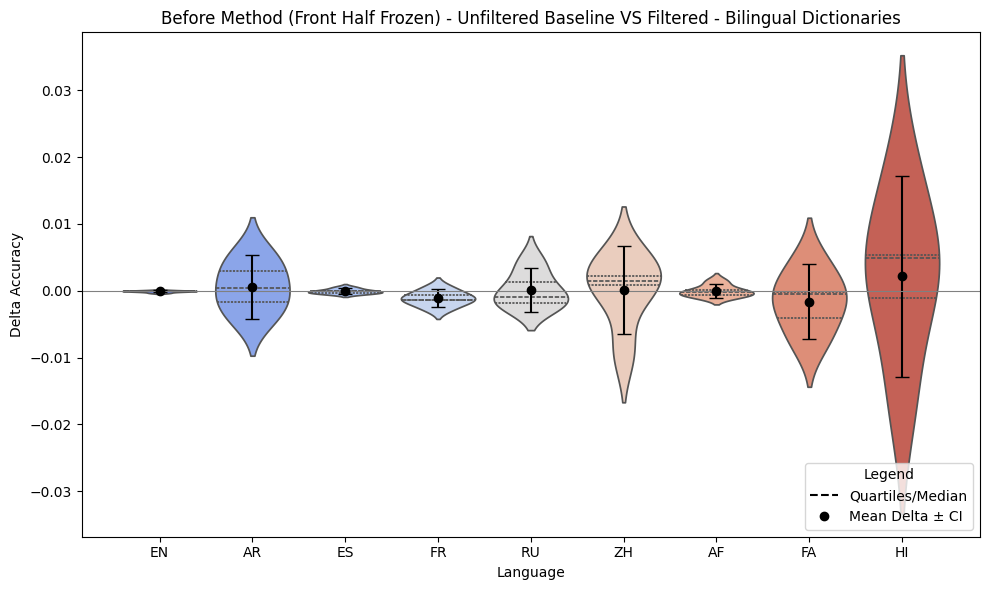

In [7]:
project_pairs = [
    ("3nl_freeze_realign_unfreeze_fastalign_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_fastalign_udpos"),
    ("3nl_freeze_realign_unfreeze_awesome_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_awesome_udpos"),
    ("3nl_freeze_realign_unfreeze_dico_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_dico_udpos"),
]
plot_individual_violin_deltas_with_cis(project_pairs, langs, title='Before Method (Front Half Frozen) - Unfiltered Baseline VS Filtered')

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


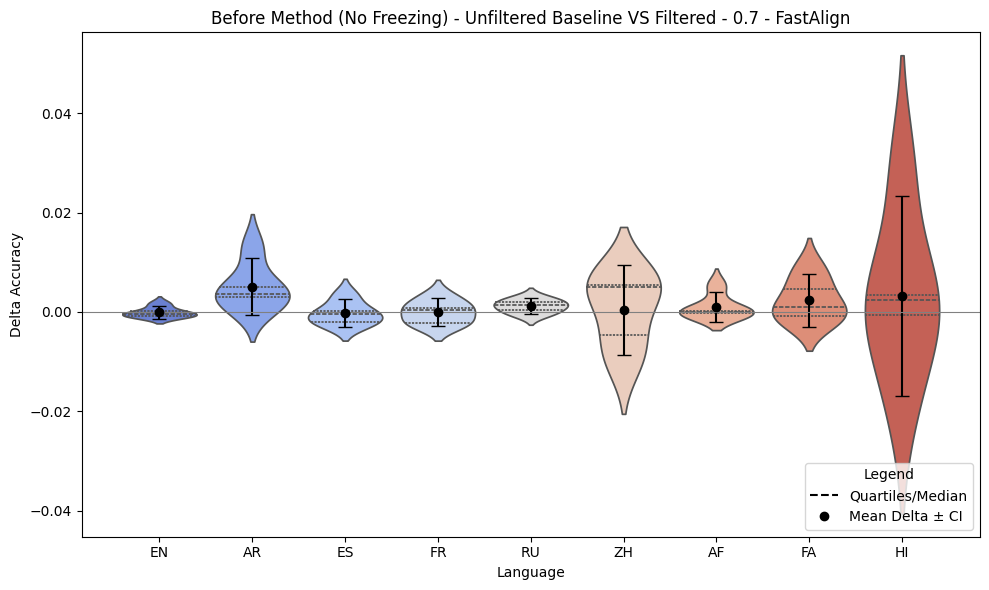

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


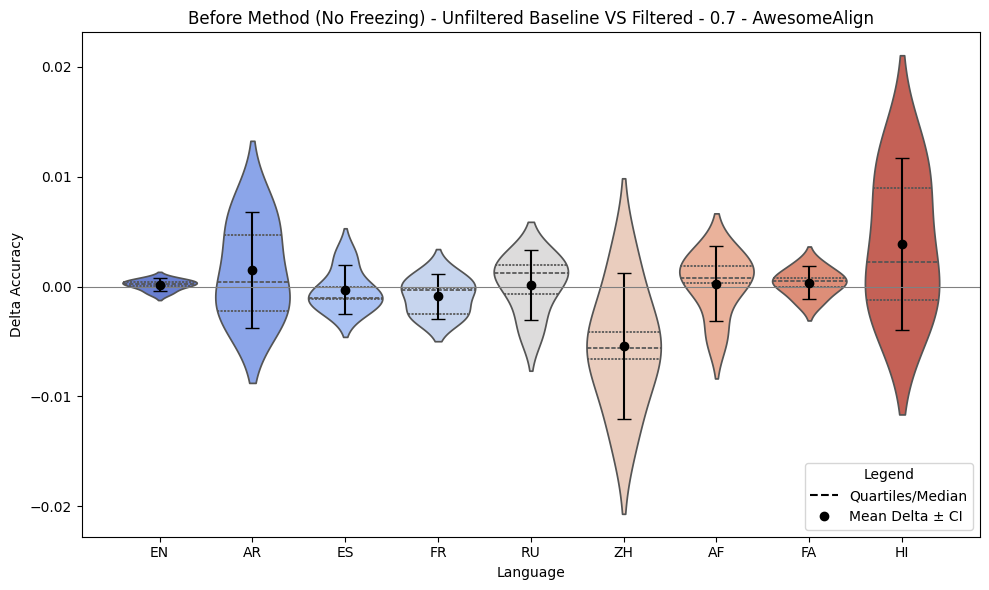

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


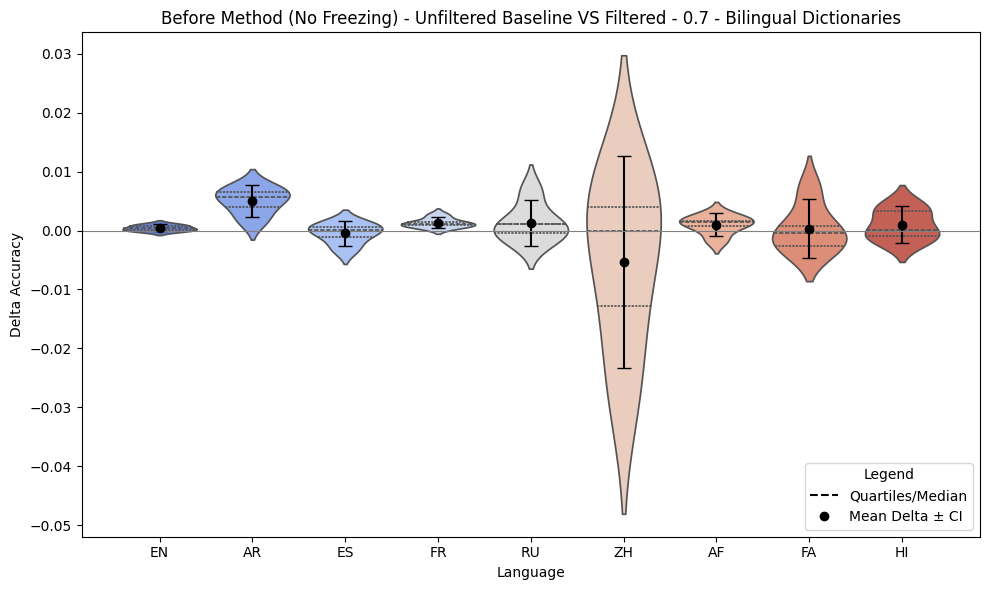

In [8]:
project_pairs = [
    ("3nl_before_fastalign_udpos", "3nl_filtered_0.7_before_fastalign_udpos"),
    ("3nl_before_awesome_udpos", "3nl_filtered_0.7_before_awesome_udpos"),
    ("3nl_before_dico_udpos", "3nl_filtered_0.7_before_dico_udpos"),
]
plot_individual_violin_deltas_with_cis(project_pairs, langs, title='Before Method (No Freezing) - Unfiltered Baseline VS Filtered - 0.7')

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


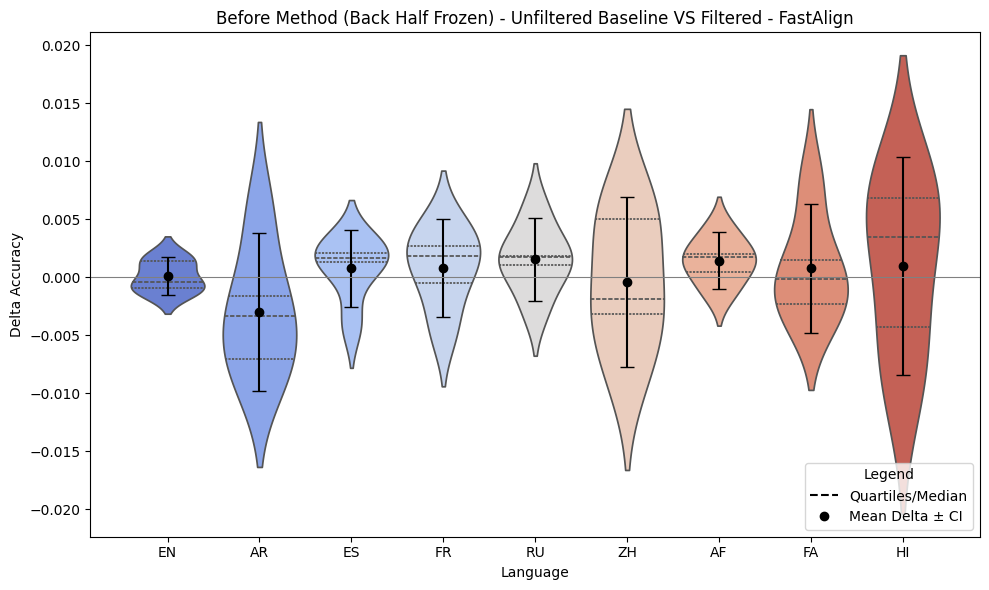

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


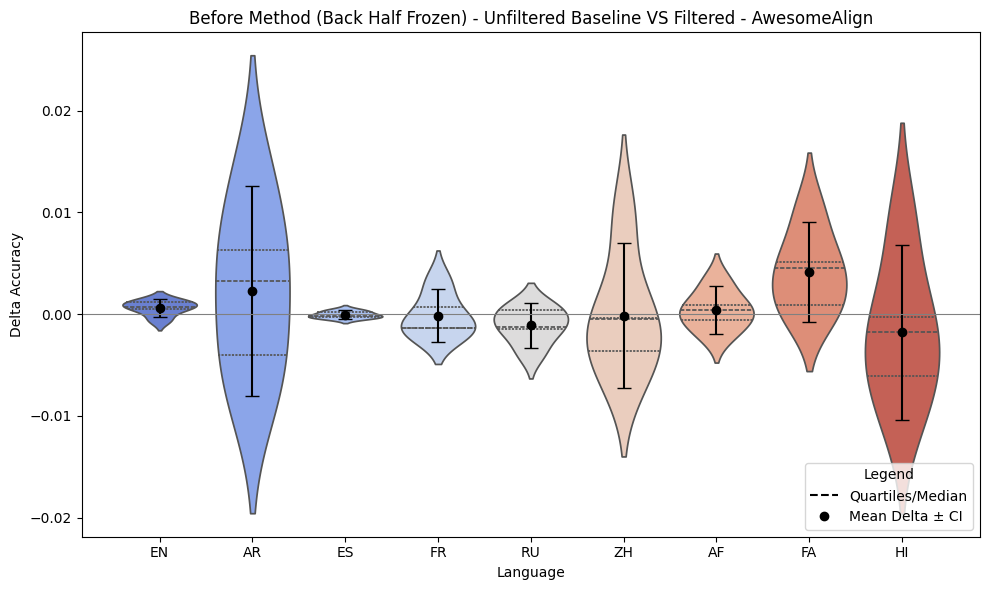

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


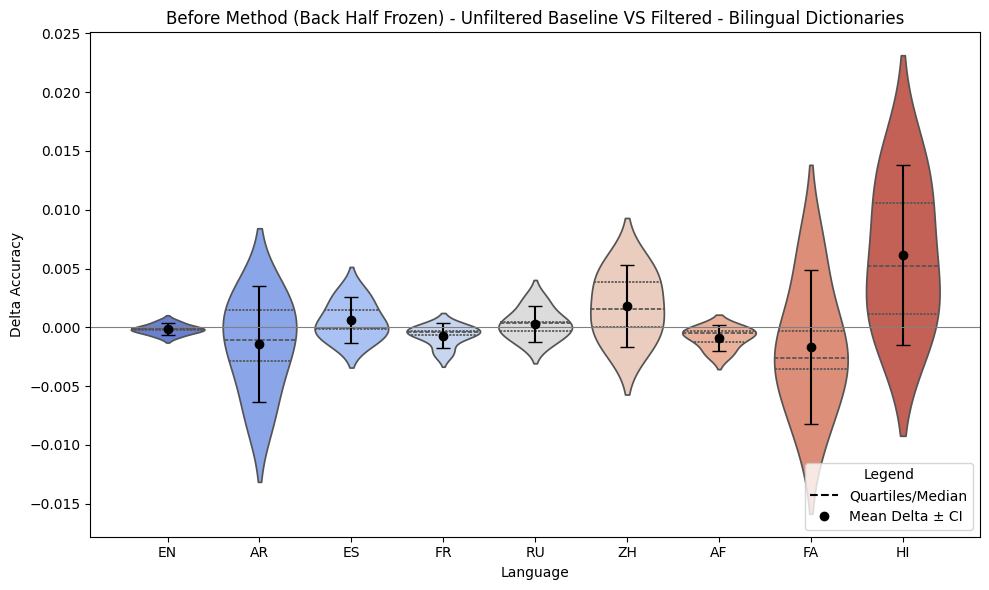

In [9]:
project_pairs = [
    ("3nl_freeze_realign_unfreeze_last_6_fastalign_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_last_6_fastalign_udpos"),
    ("3nl_freeze_realign_unfreeze_last_6_awesome_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_last_6_awesome_udpos"),
    ("3nl_freeze_realign_unfreeze_last_6_dico_udpos", "3nl_filtered_0.5_freeze_realign_unfreeze_last_6_dico_udpos"),
]
plot_individual_violin_deltas_with_cis(project_pairs, langs, title='Before Method (Back Half Frozen) - Unfiltered Baseline VS Filtered')

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


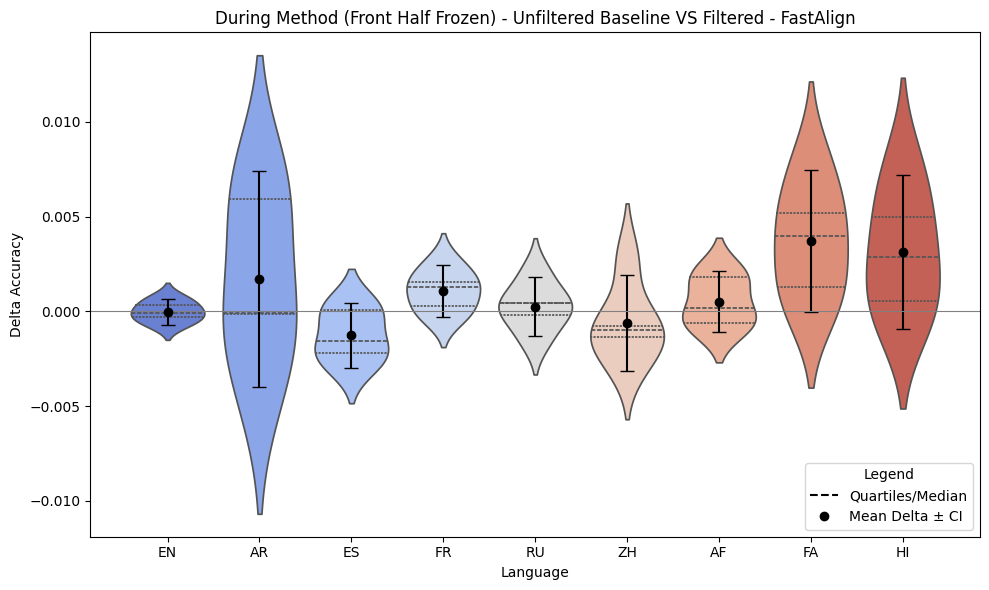

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


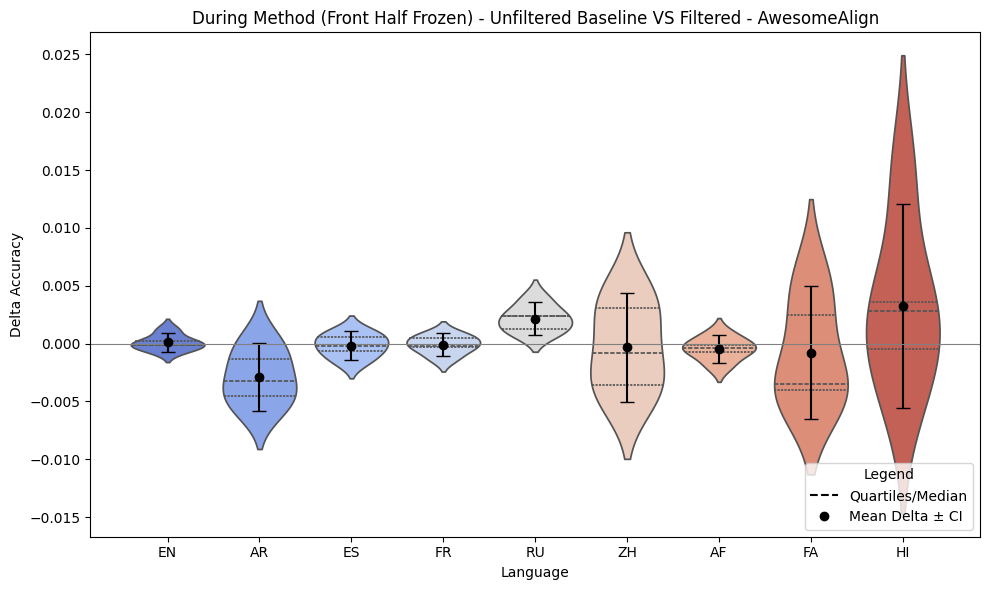

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


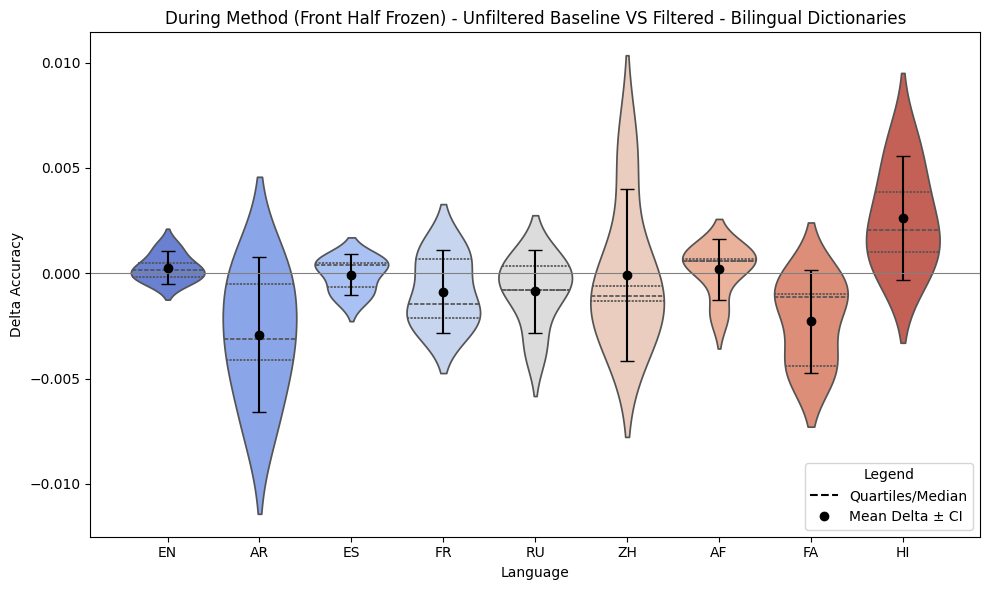

In [10]:
project_pairs = [
    ("3nl_during_partial_freeze_front_fastalign_udpos", "3nl_filtered_0.5_during_partial_freeze_front_fastalign_udpos"),
    ("3nl_during_partial_freeze_front_awesome_udpos", "3nl_filtered_0.5_during_partial_freeze_front_awesome_udpos"),
    ("3nl_during_partial_freeze_front_dico_udpos", "3nl_filtered_0.5_during_partial_freeze_front_dico_udpos"),
]
plot_individual_violin_deltas_with_cis(project_pairs, langs, title='During Method (Front Half Frozen) - Unfiltered Baseline VS Filtered')

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


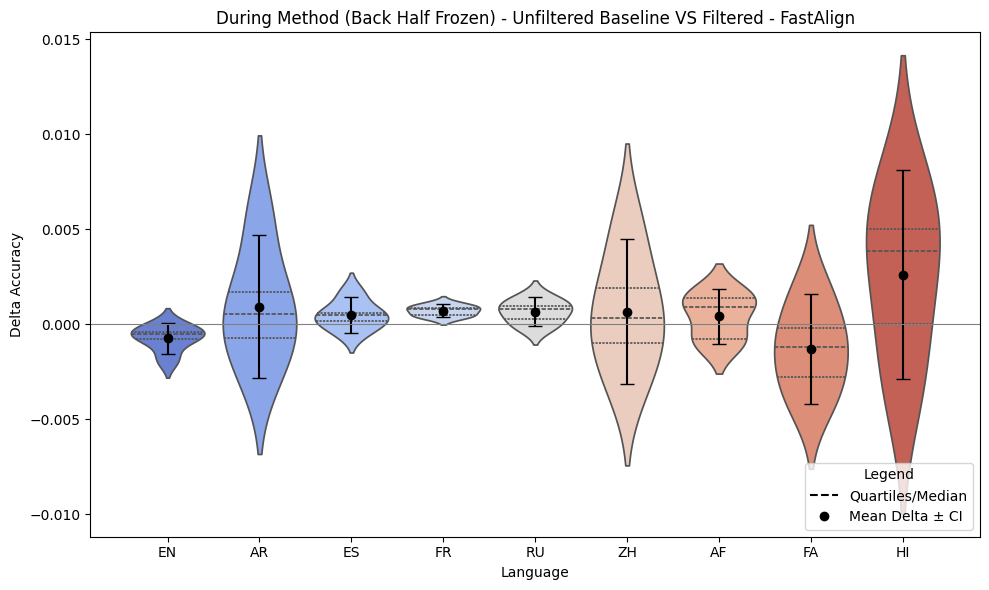

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


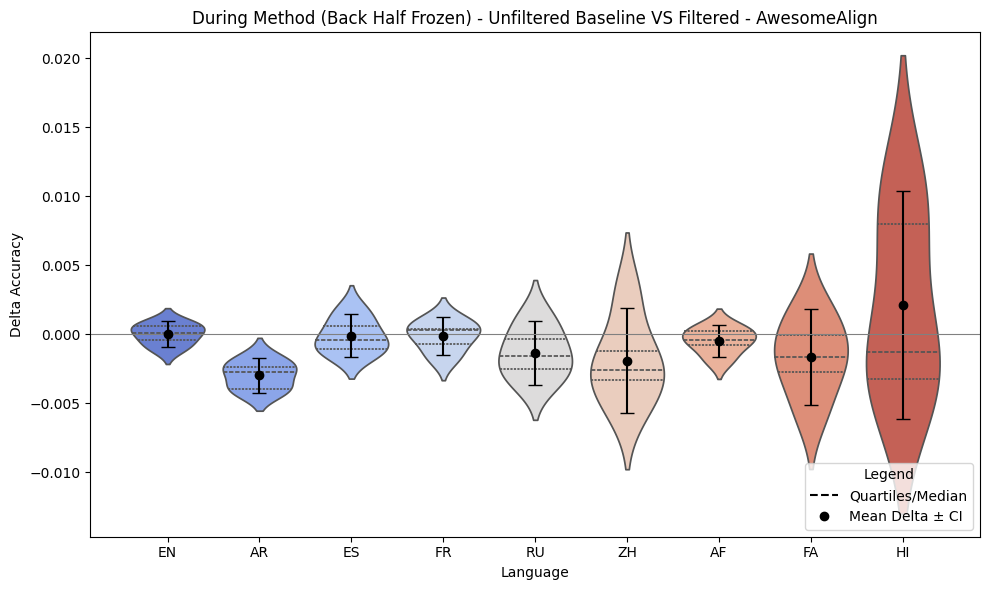

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


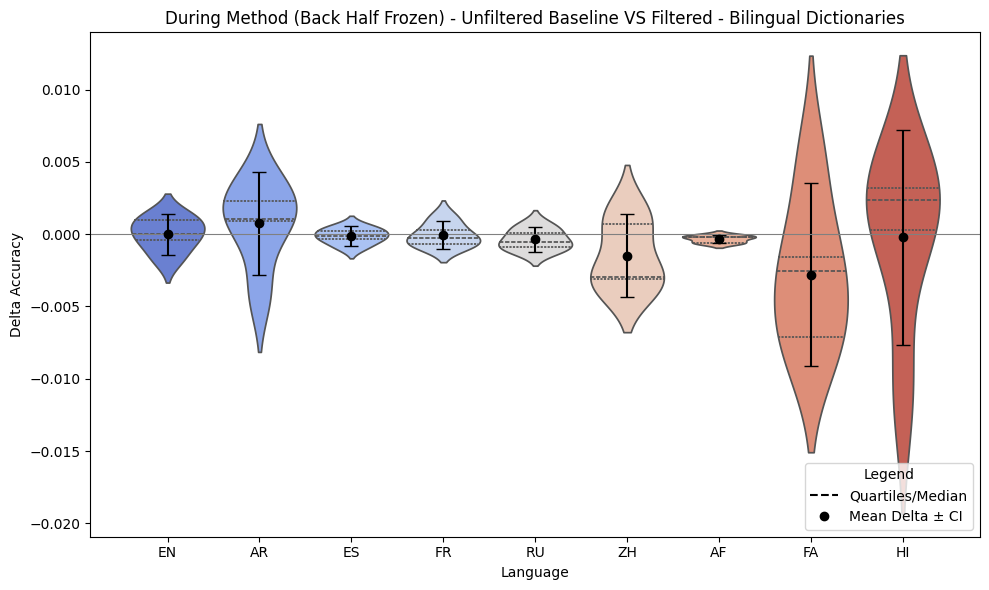

In [11]:
project_pairs = [
    ("3nl_during_partial_freeze_back_fastalign_udpos", "3nl_filtered_0.5_during_partial_freeze_back_fastalign_udpos"),
    ("3nl_during_partial_freeze_back_awesome_udpos", "3nl_filtered_0.5_during_partial_freeze_back_awesome_udpos"),
    ("3nl_during_partial_freeze_back_dico_udpos", "3nl_filtered_0.5_during_partial_freeze_back_dico_udpos"),
]
plot_individual_violin_deltas_with_cis(project_pairs, langs, title='During Method (Back Half Frozen) - Unfiltered Baseline VS Filtered')

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


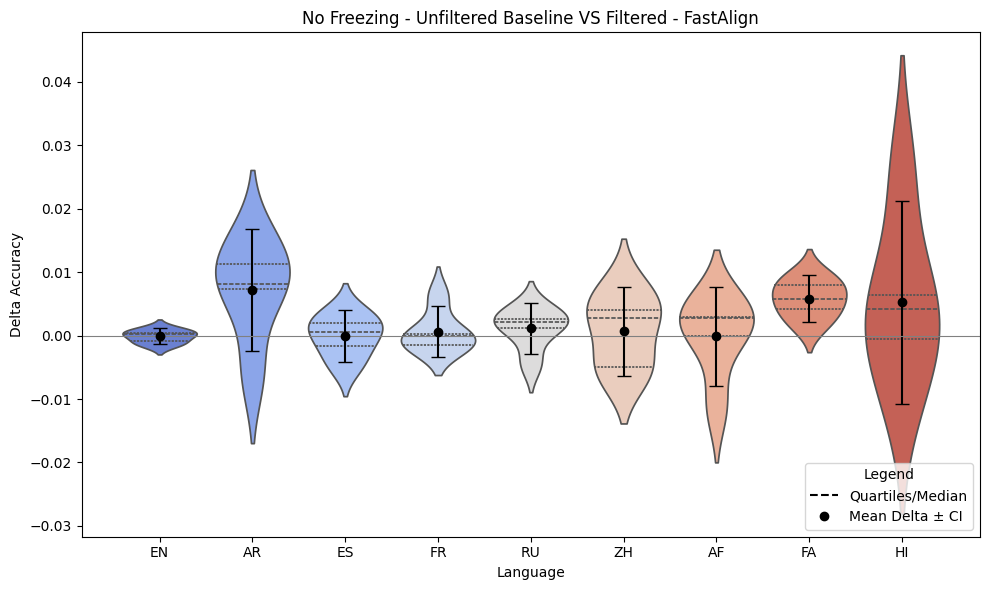

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


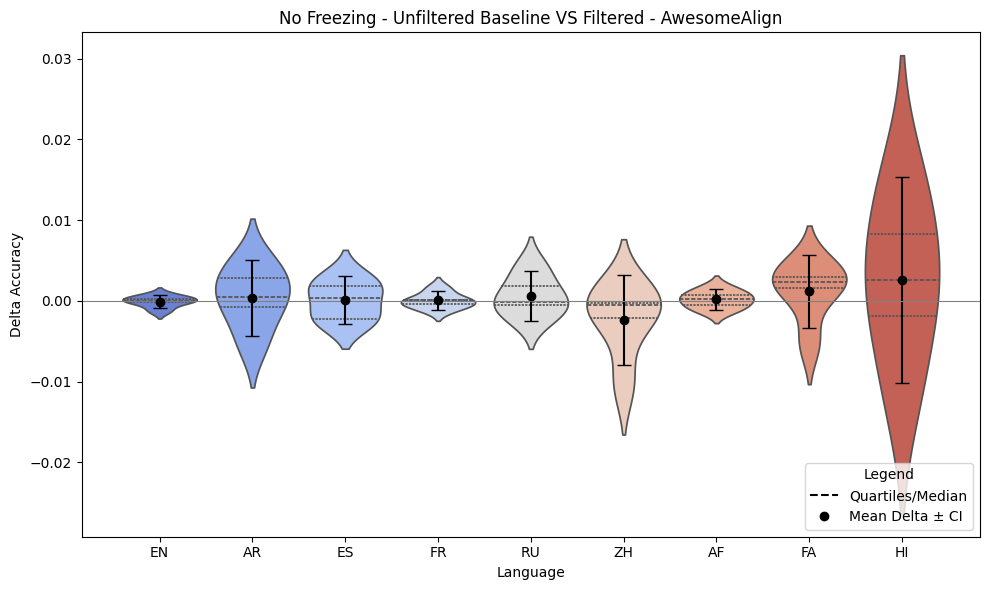

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


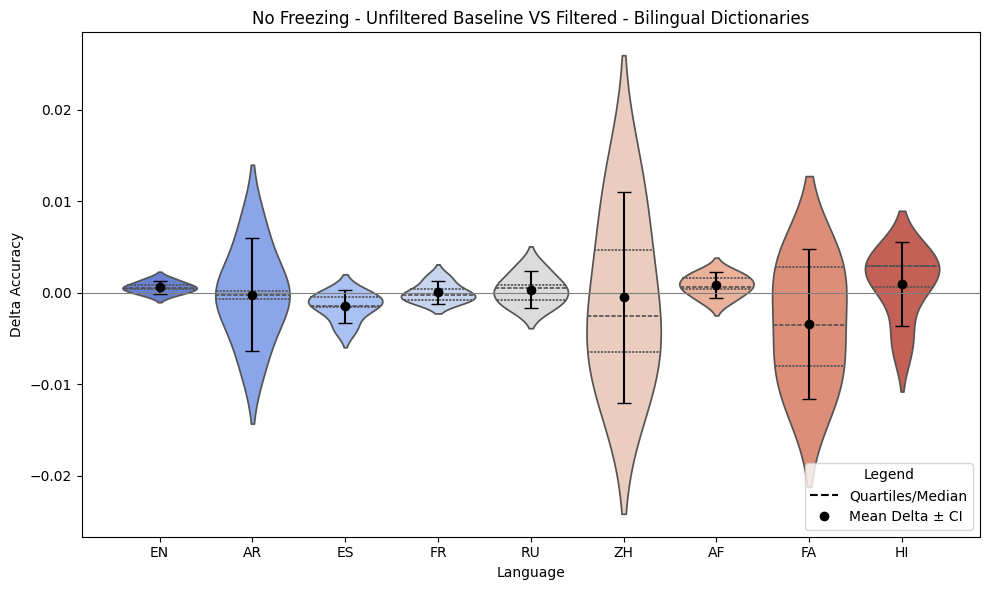

In [12]:
project_pairs = [
    ("3nl_before_fastalign_udpos", "3nl_filtered_0.5_before_fastalign_udpos"),
    ("3nl_before_awesome_udpos", "3nl_filtered_0.5_before_awesome_udpos"),
    ("3nl_before_dico_udpos", "3nl_filtered_0.5_before_dico_udpos"),
]
plot_individual_violin_deltas_with_cis(project_pairs, langs, title='No Freezing - Unfiltered Baseline VS Filtered')

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


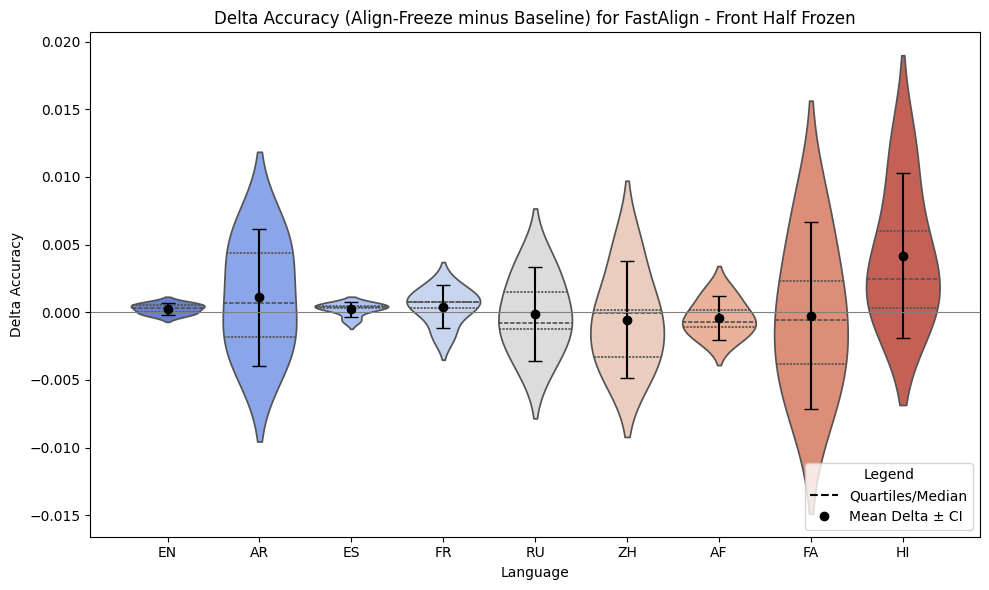

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


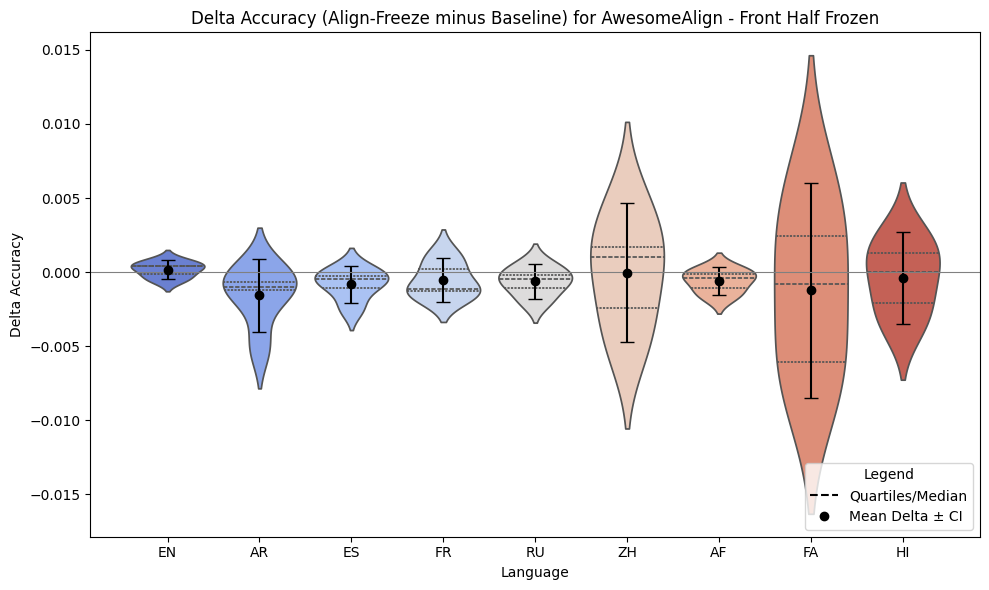

C:\Users\alith\AppData\Local\Temp\ipykernel_81156\664432910.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['EN' if lang == 'same' else lang.upper() for lang in langs])


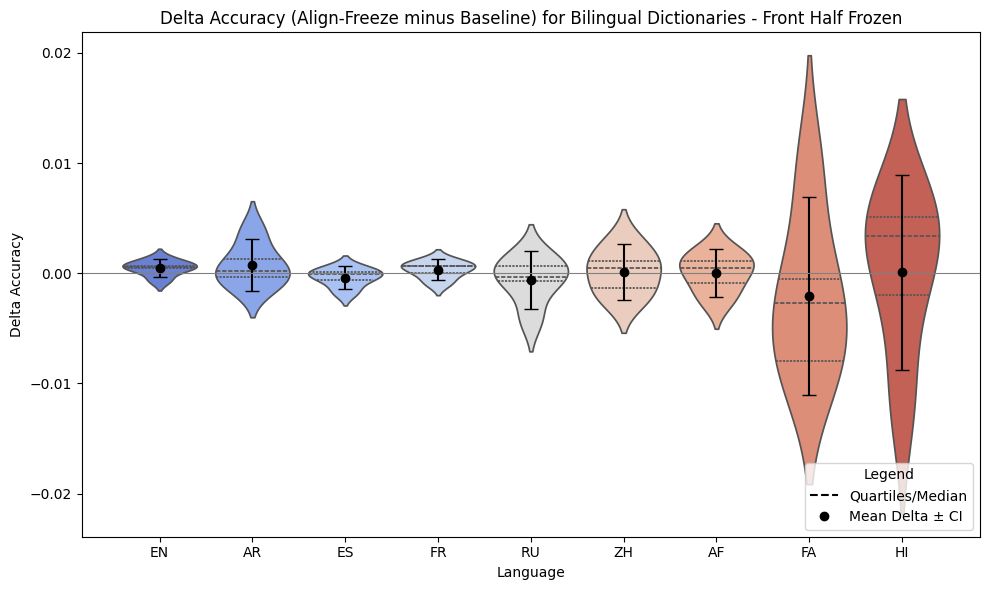

In [13]:
project_pairs = [
    ("3nl_during_fastalign_udpos", "3nl_filtered_0.5_during_fastalign_udpos"),
    ("3nl_during_awesome_udpos", "3nl_filtered_0.5_during_awesome_udpos"),
    ("3nl_during_dico_udpos", "3nl_filtered_0.5_during_dico_udpos"),
]
plot_individual_violin_deltas_with_cis(project_pairs, langs)

In [14]:

def plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triples, langs, grouping, group_name):
    titles = ['FastAlign', 'AwesomeAlign', 'Bilingual Dictionaries']

    for project_idx, (baseline_project, front_half_frozen_project, back_half_frozen_project) in enumerate(project_triples):
        all_delta_data = []
        baseline_data = fetch_and_process_runs(baseline_project)
        front_half_frozen_data = fetch_and_process_runs(front_half_frozen_project)
        back_half_frozen_data = fetch_and_process_runs(back_half_frozen_project)

        for lang in langs:
            front_deltas = [front - baseline for baseline, front in zip(baseline_data[lang], front_half_frozen_data[lang])]
            back_deltas = [back - baseline for baseline, back in zip(baseline_data[lang], back_half_frozen_data[lang])]
            group = grouping.get(lang, 'Other')
            all_delta_data.extend([{'Group': group, 'Delta': delta, 'Type': 'Front Half Frozen'} for delta in front_deltas])
            all_delta_data.extend([{'Group': group, 'Delta': delta, 'Type': 'Back Half Frozen'} for delta in back_deltas])

        df = pd.DataFrame(all_delta_data)
        plt.figure(figsize=(12, 6))
        ax = sns.violinplot(x='Group', y='Delta', hue='Type', data=df, split=True, inner='quartile', palette='coolwarm', width=1.2)

        plt.title(f'Delta Accuracy Comparison by {group_name} - {titles[project_idx]}')
        plt.axhline(0, color='grey', linewidth=0.8)
        plt.ylabel('Delta Accuracy')
        ax.legend(title="Frozen Half")

        unique_groups = df['Group'].unique()
        group_positions = ax.get_xticks()
        hue_order = ['Front Half Frozen', 'Back Half Frozen']
        
        offset = 0.05  

        for i, group in enumerate(unique_groups):
            group_pos = group_positions[i]
            for j, type_label in enumerate(hue_order):
                subset = df[(df['Group'] == group) & (df['Type'] == type_label)]
                mean = subset['Delta'].mean()
                ci = scipy.stats.sem(subset['Delta']) * scipy.stats.t.ppf((1 + 0.95) / 2., len(subset['Delta'])-1)
                
                position = group_pos - offset if type_label == 'Front Half Frozen' else group_pos + offset
                plt.errorbar(position, mean, yerr=ci, fmt='o', color='black', capsize=5, capthick=2)

        plt.tight_layout()
        plt.show()

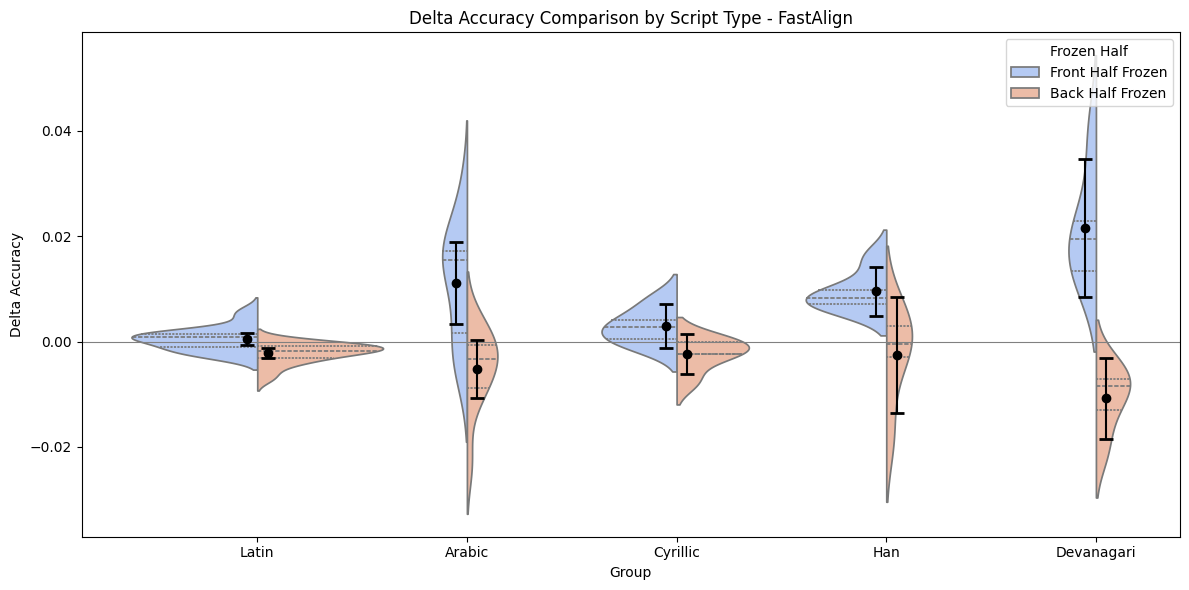

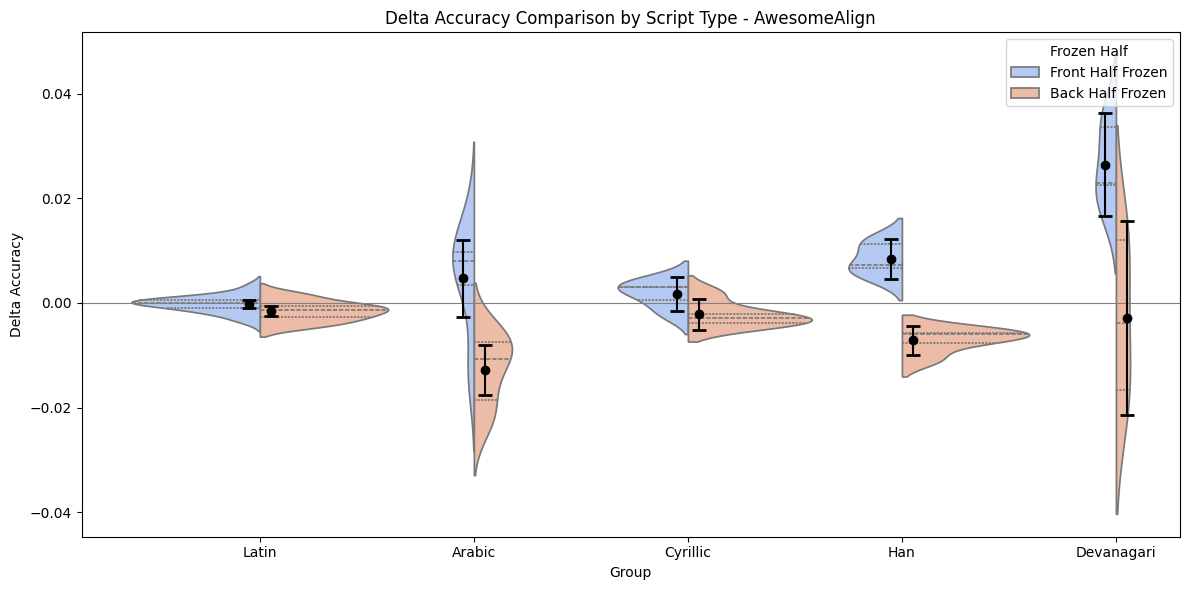

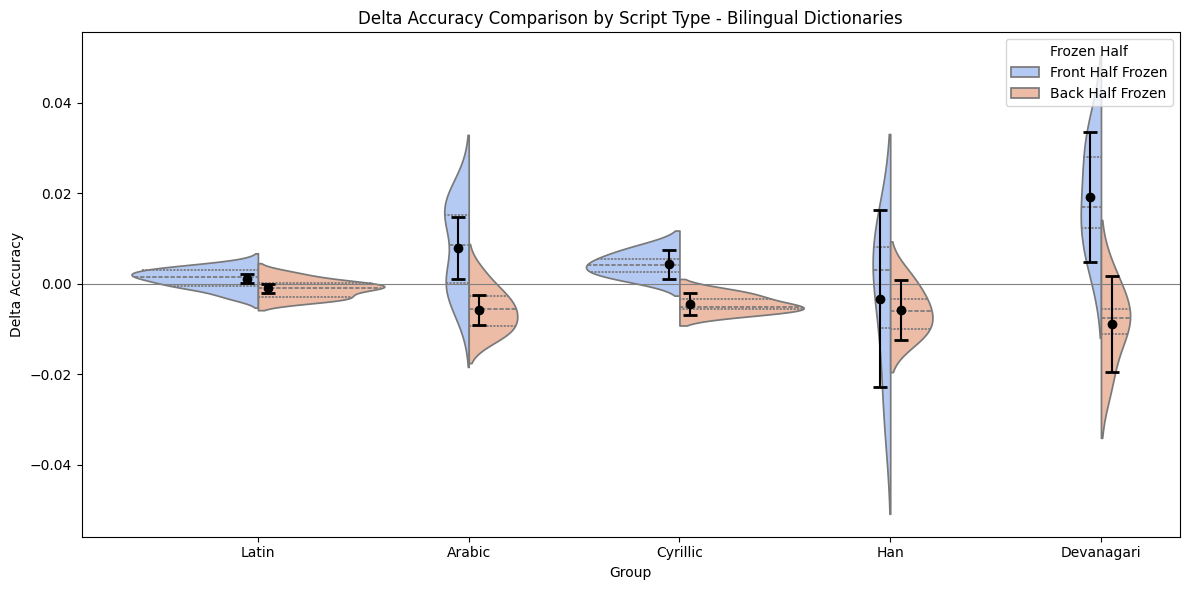

In [15]:

project_triple = [
    ("3nl_before_fastalign_udpos", "3nl_freeze_realign_unfreeze_fastalign_udpos", "3nl_freeze_realign_unfreeze_last_6_fastalign_udpos"),
    ("3nl_before_awesome_udpos", "3nl_freeze_realign_unfreeze_awesome_udpos", "3nl_freeze_realign_unfreeze_last_6_awesome_udpos"),
    ("3nl_before_dico_udpos", "3nl_freeze_realign_unfreeze_dico_udpos", "3nl_freeze_realign_unfreeze_last_6_dico_udpos"),
]


grouping = {
    'same': 'Latin',  
    'ar': 'Arabic',
    'es': 'Latin',
    'fr': 'Latin',
    'ru': 'Cyrillic',
    'zh': 'Han',
    'af': 'Latin',
    'fa': 'Arabic',
    'hi': 'Devanagari'
}

plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triple, langs, grouping, 'Script Type')

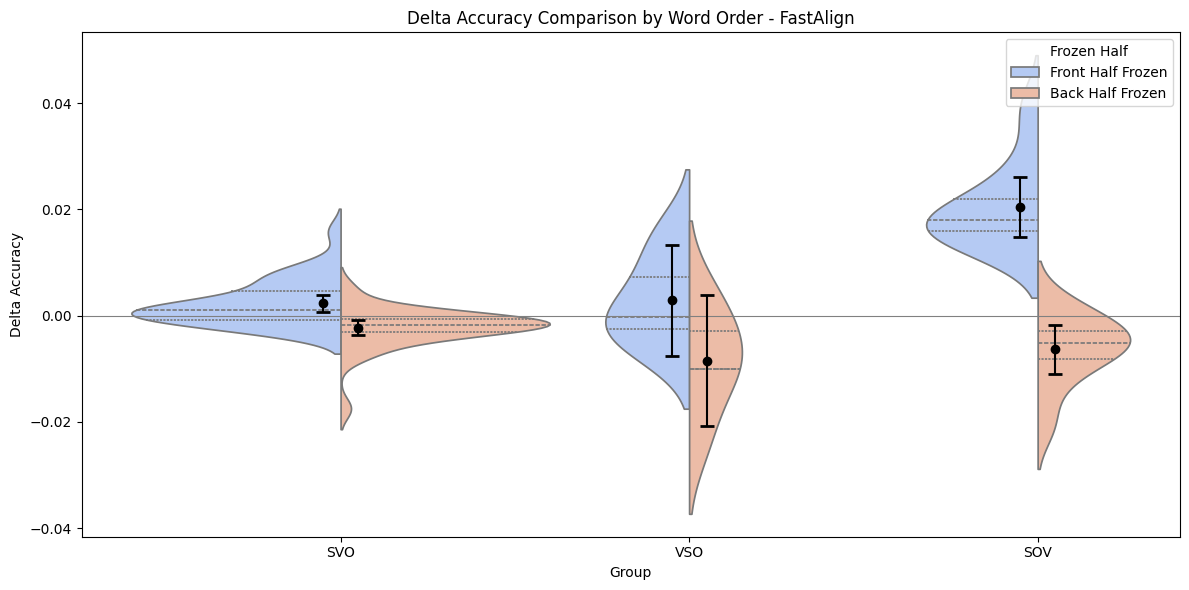

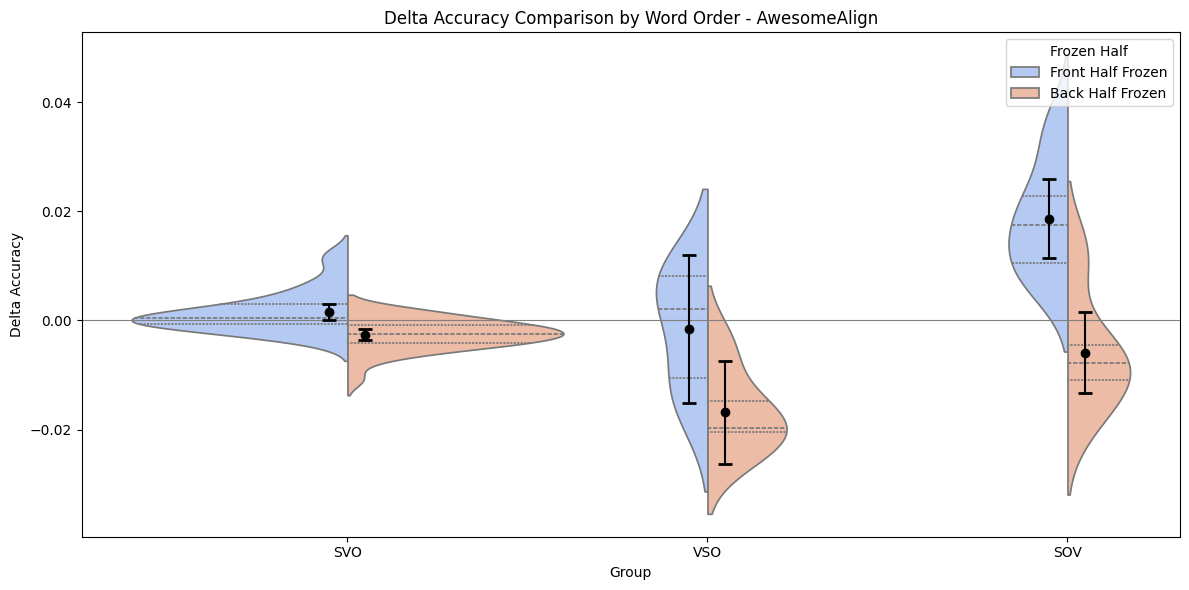

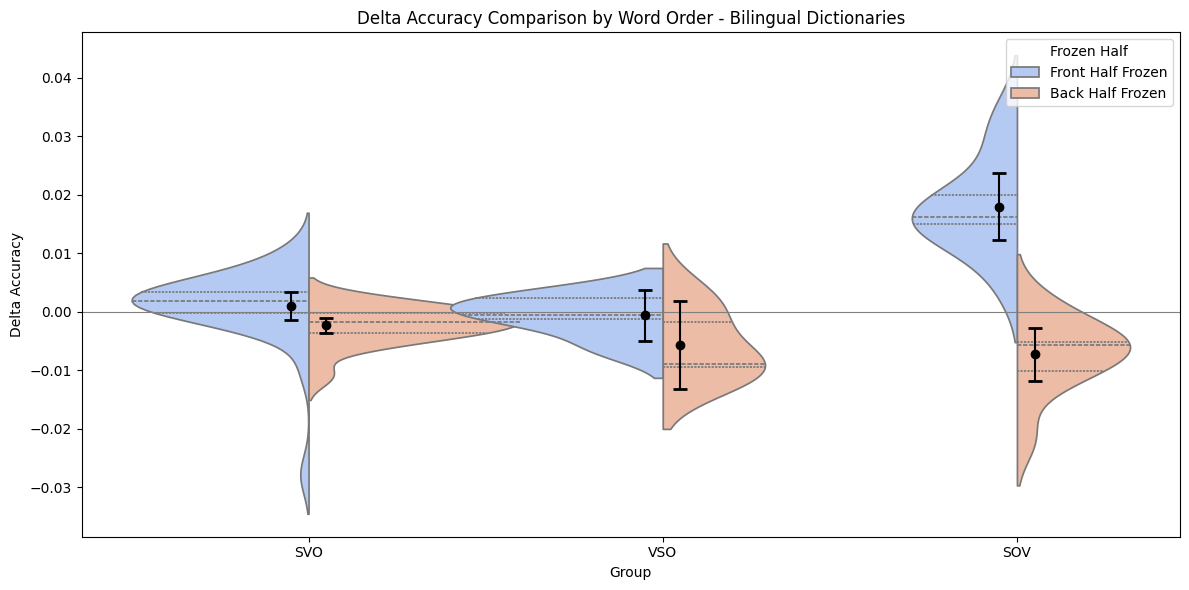

In [16]:
grouping = {
    'same': 'SVO',  
    'ar': 'VSO',  
    'es': 'SVO',  
    'fr': 'SVO',  
    'ru': 'SVO',  
    'zh': 'SVO',  
    'af': 'SVO',  
    'fa': 'SOV',  
    'hi': 'SOV'   
}

plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triple, langs, grouping, 'Word Order')


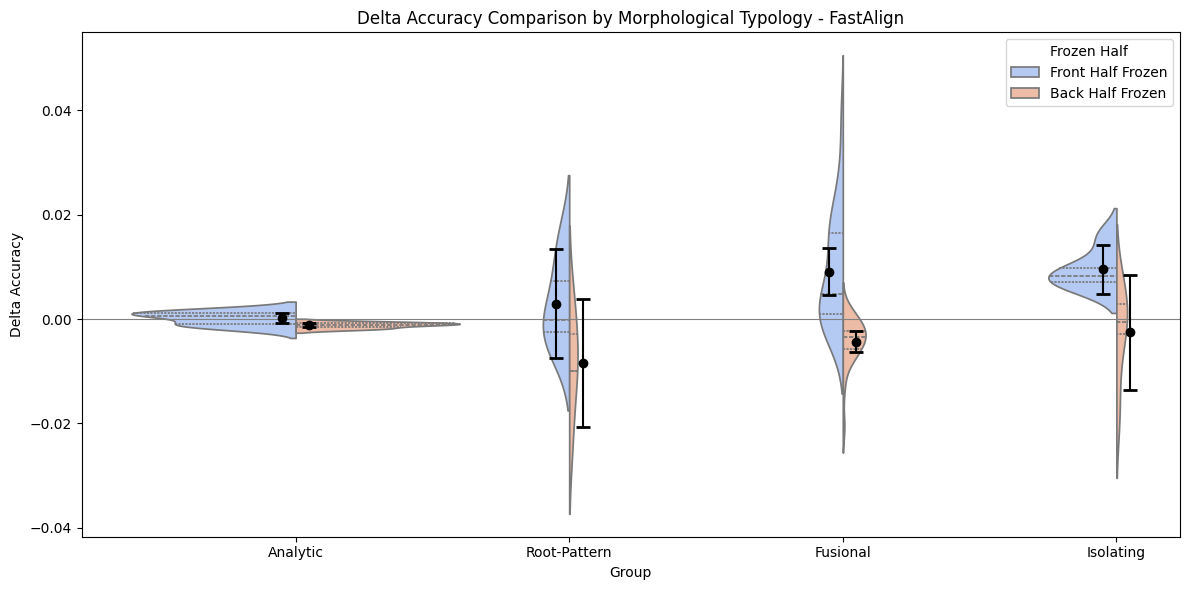

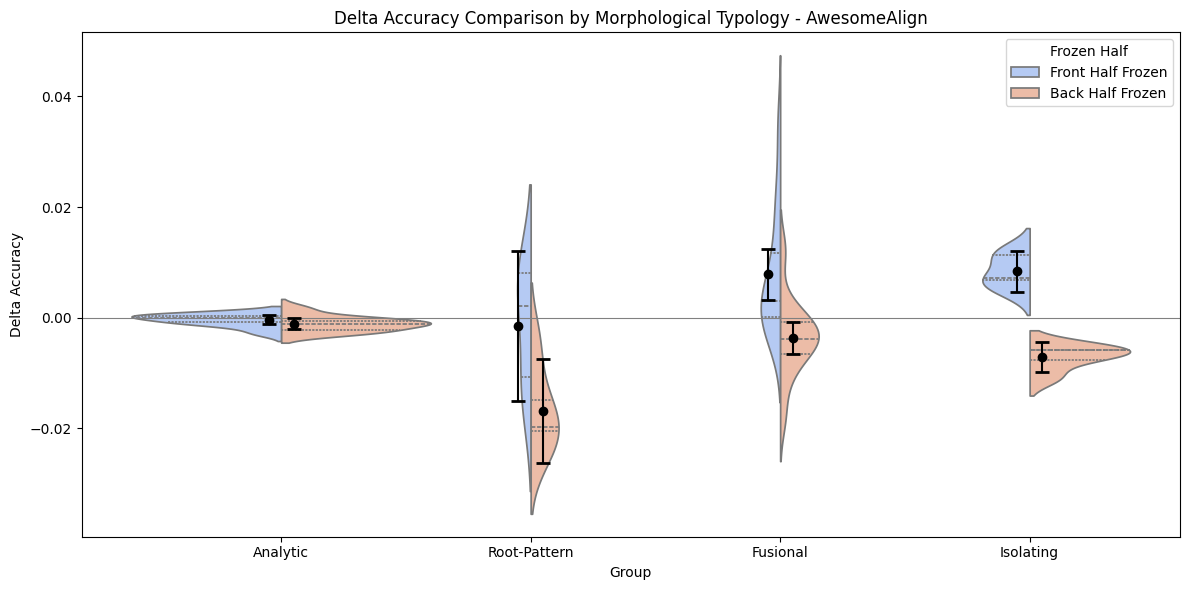

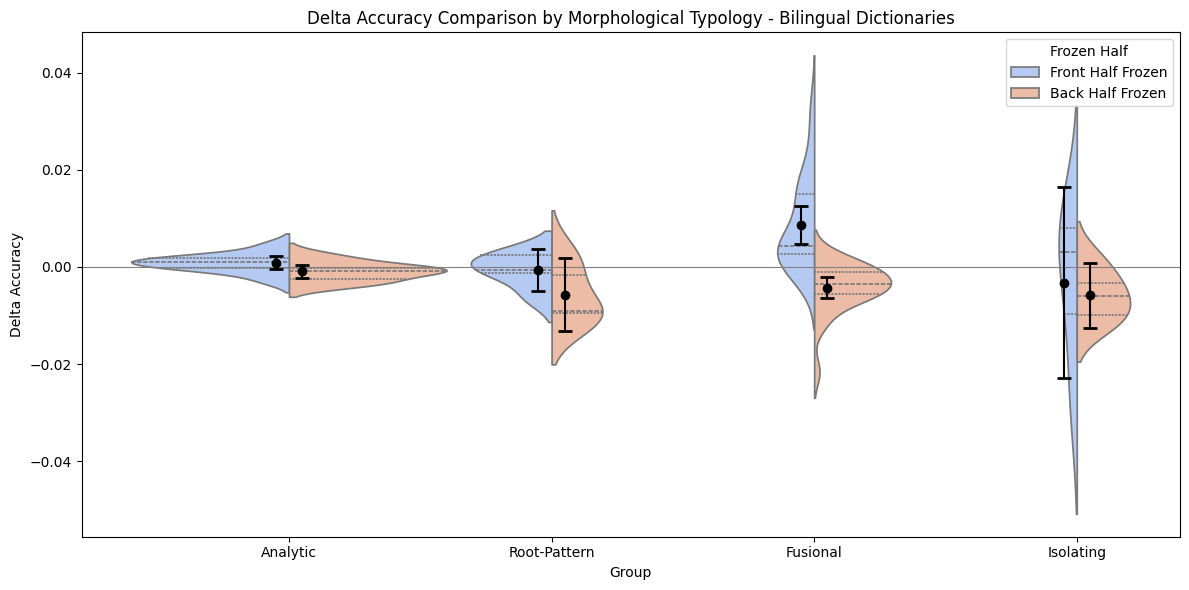

In [17]:
grouping = {
    'same': 'Analytic',   
    'ar': 'Root-Pattern', 
    'es': 'Fusional',     
    'fr': 'Fusional',     
    'ru': 'Fusional',     
    'zh': 'Isolating',    
    'af': 'Analytic',     
    'fa': 'Fusional',     
    'hi': 'Fusional'      
}

plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triple, langs, grouping, 'Morphological Typology')

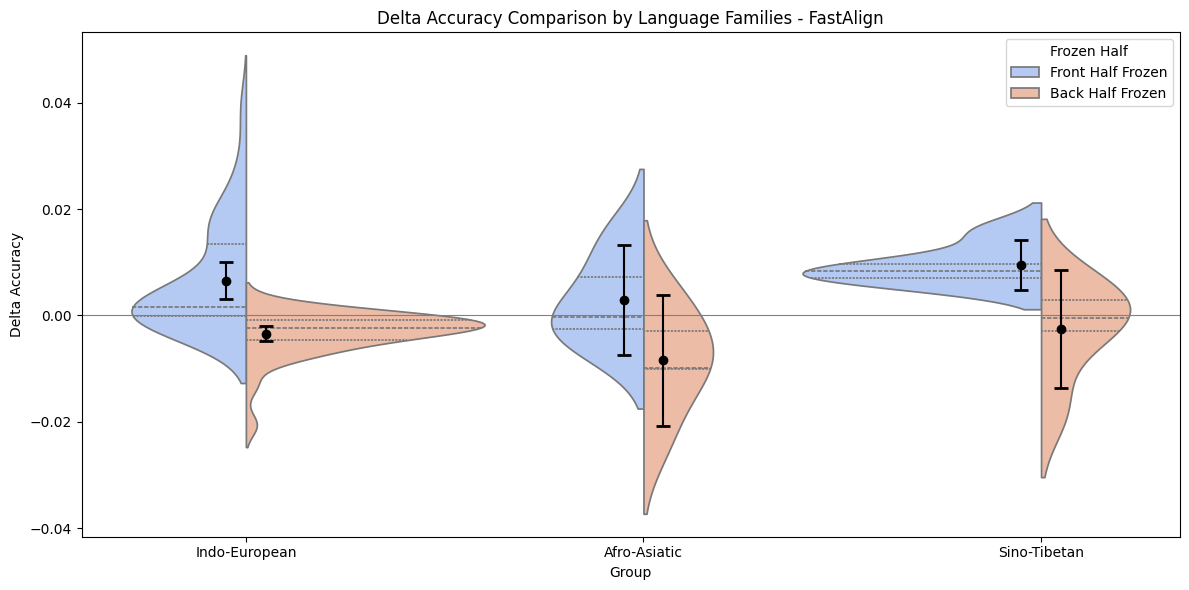

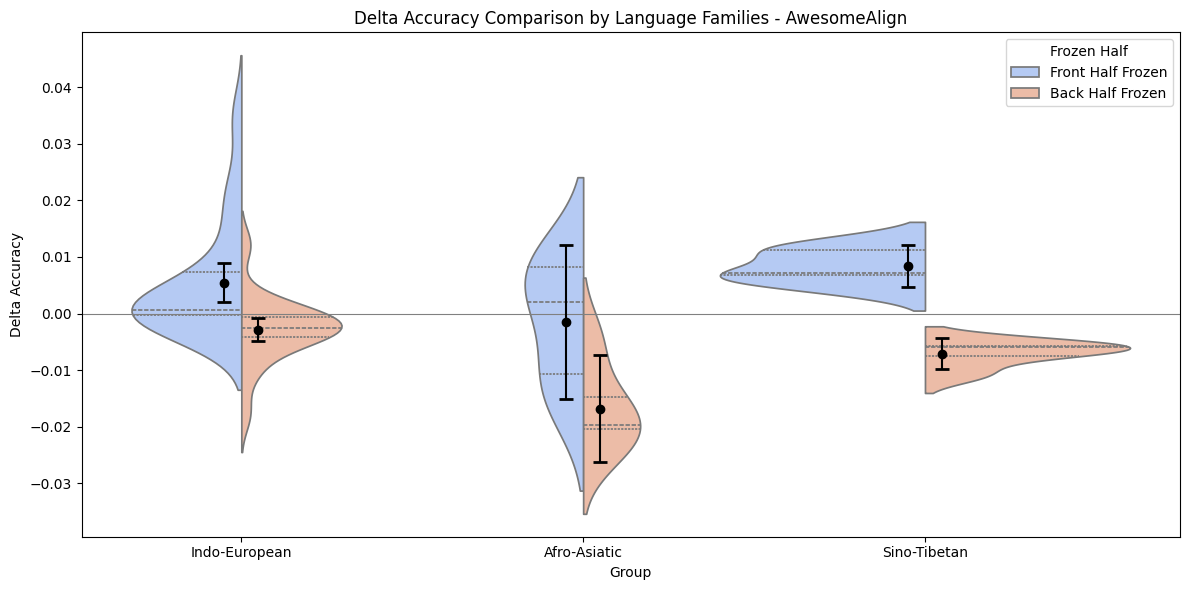

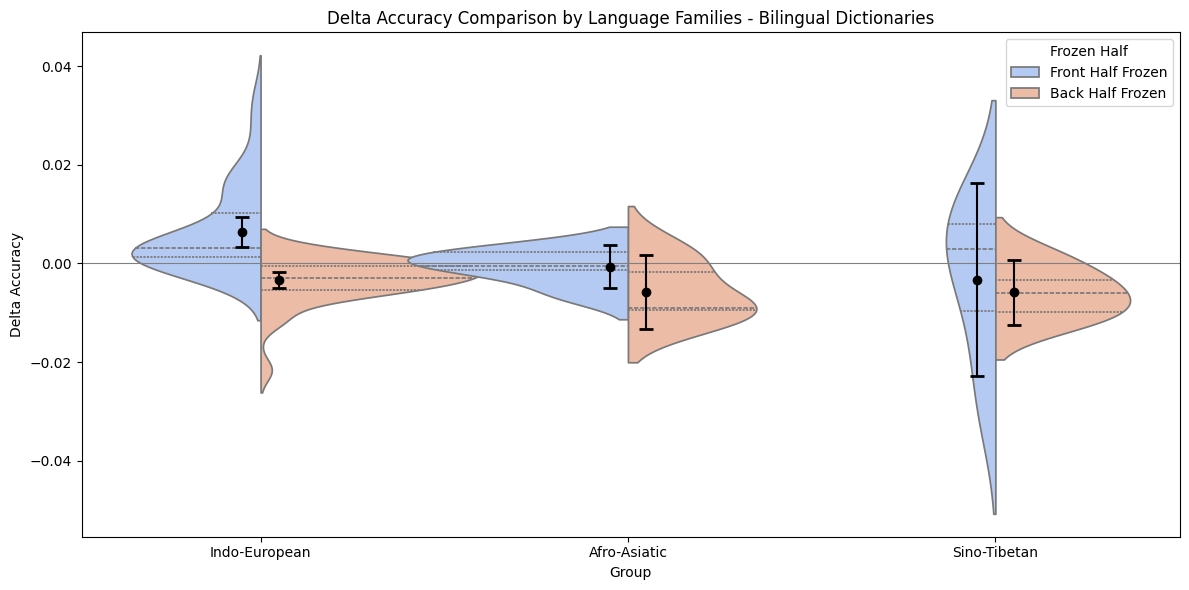

In [18]:
grouping = {
    'same': 'Indo-European',  
    'ar': 'Afro-Asiatic',   
    'es': 'Indo-European',  
    'fr': 'Indo-European',  
    'ru': 'Indo-European',  
    'zh': 'Sino-Tibetan',   
    'af': 'Indo-European',  
    'fa': 'Indo-European',  
    'hi': 'Indo-European'   
}

plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triple, langs, grouping, 'Language Families')

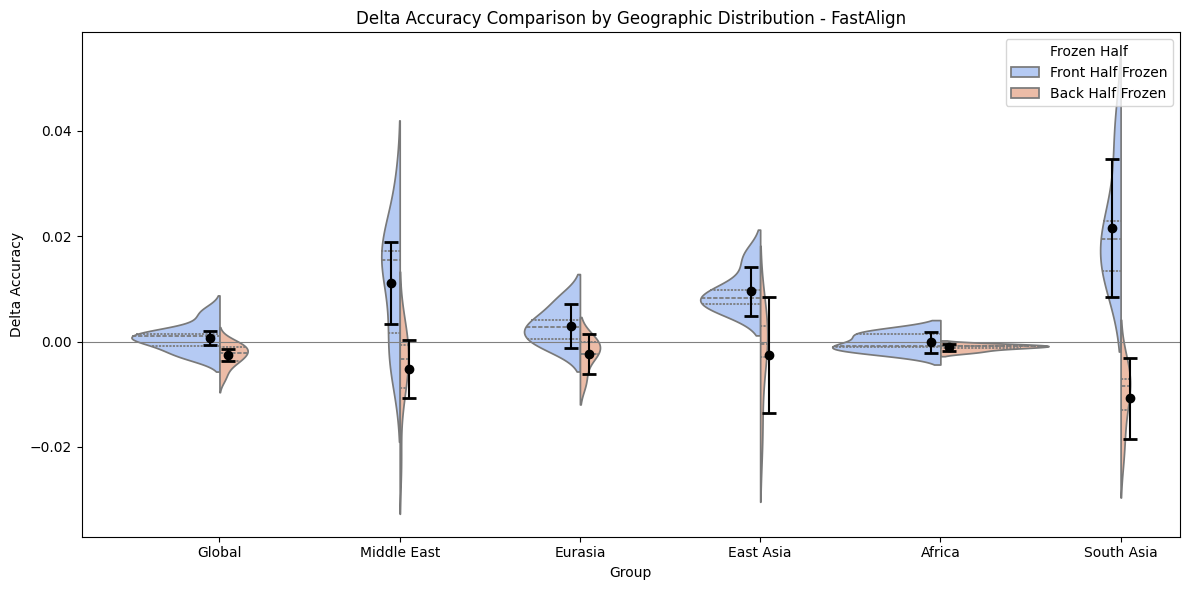

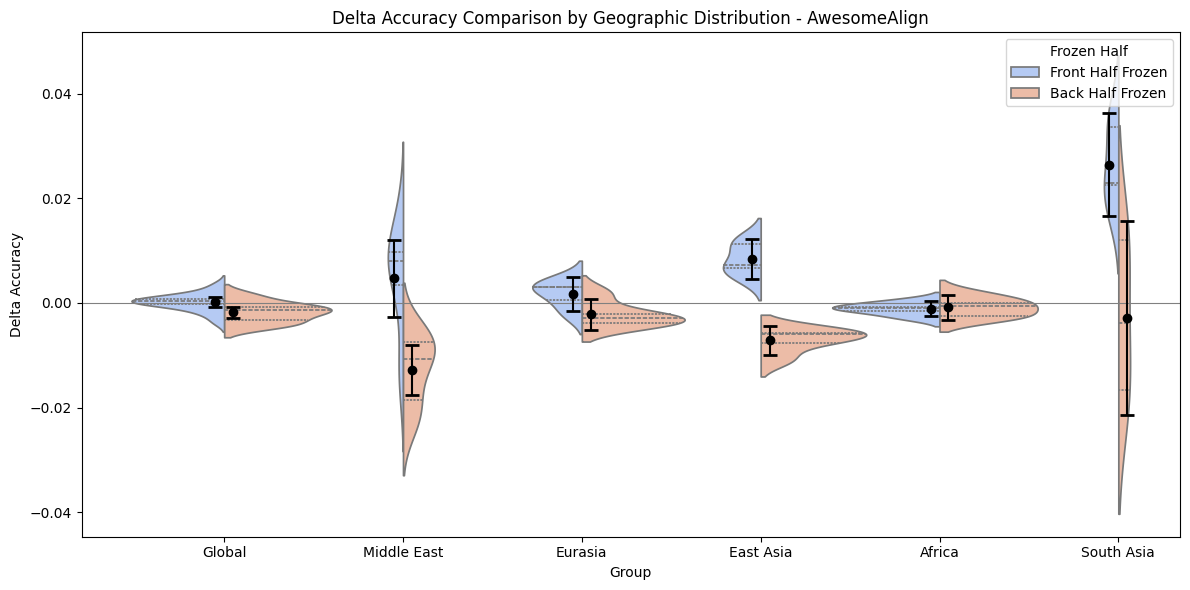

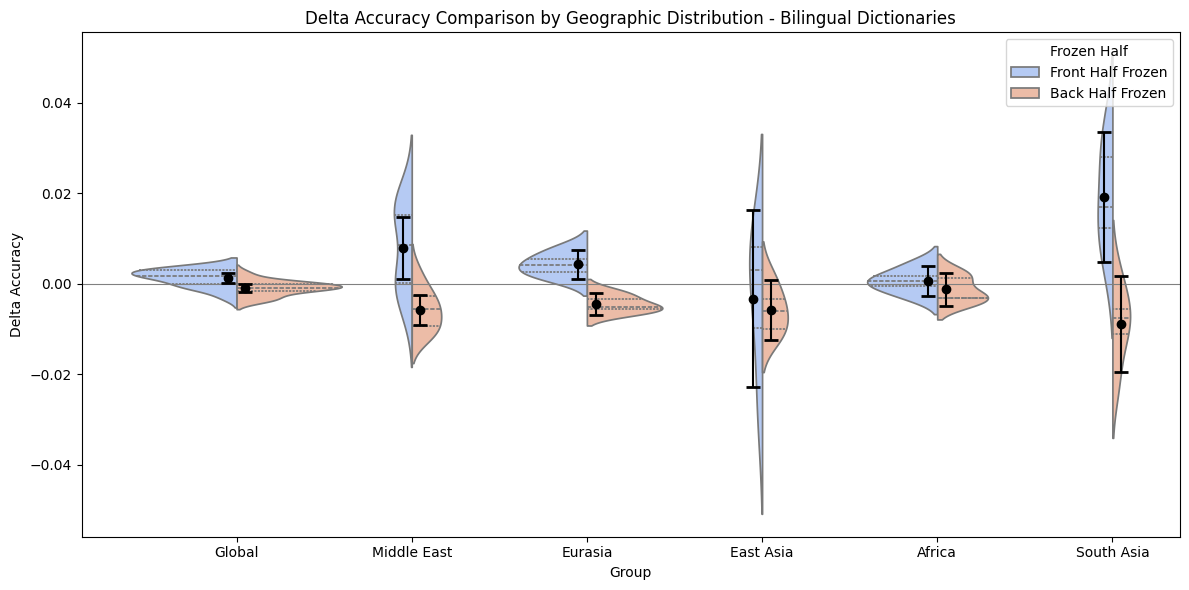

In [19]:
grouping = {
    'same': 'Global',    
    'ar': 'Middle East',  
    'es': 'Global',    
    'fr': 'Global',    
    'ru': 'Eurasia',   
    'zh': 'East Asia', 
    'af': 'Africa',    
    'fa': 'Middle East',  
    'hi': 'South Asia'  
}

plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triple, langs, grouping, 'Geographic Distribution')

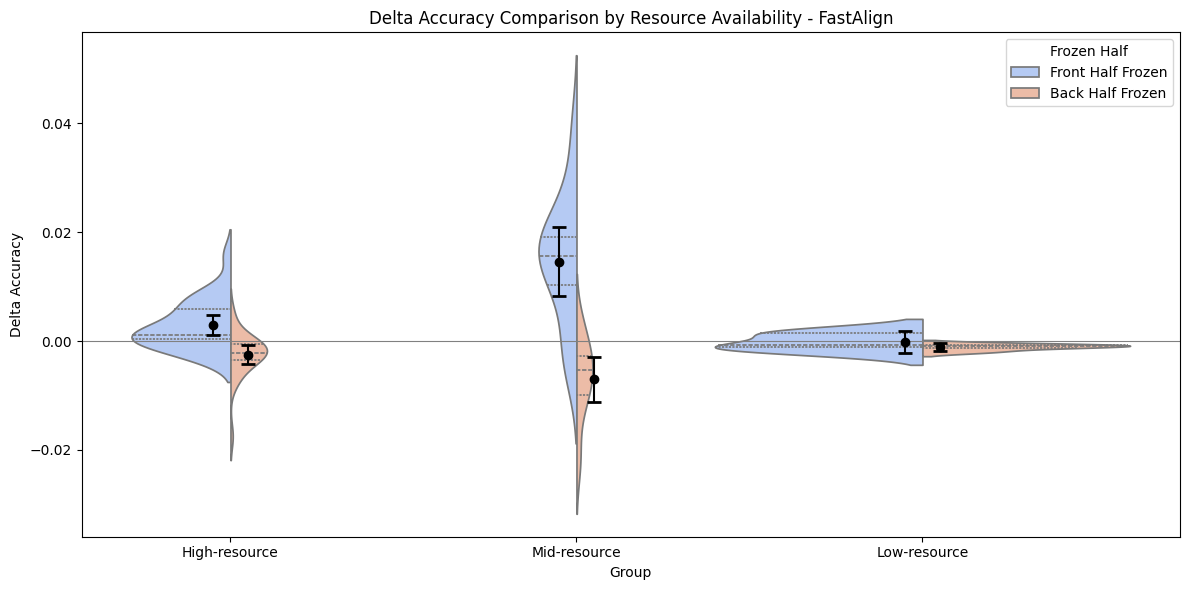

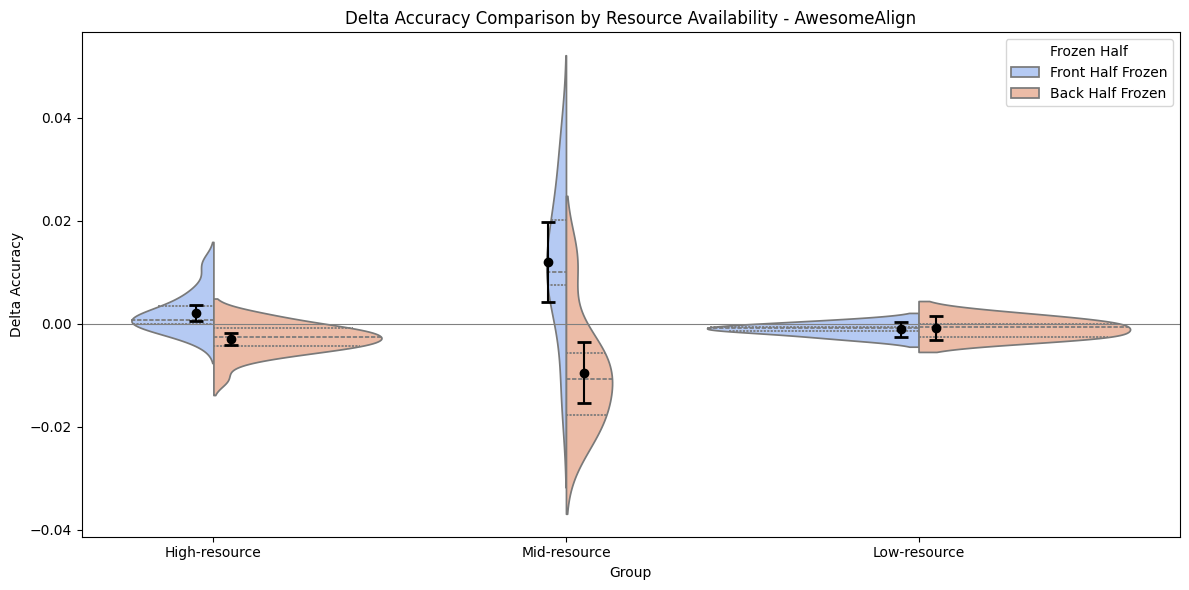

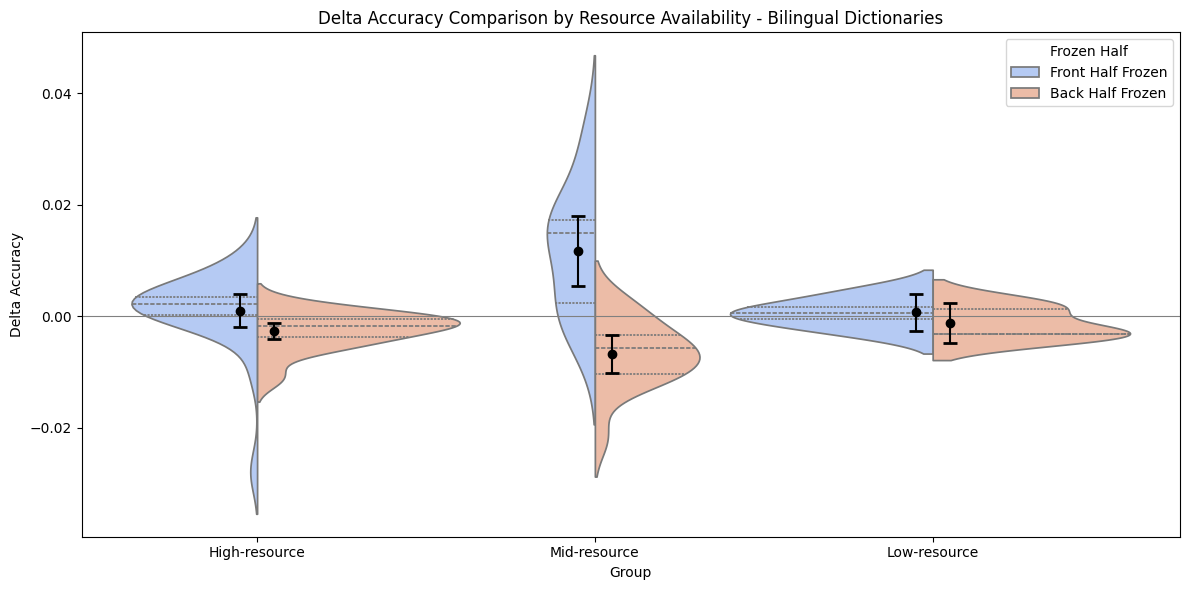

In [20]:
grouping = {
    'same': 'High-resource',    
    'ar': 'Mid-resource',     
    'es': 'High-resource',    
    'fr': 'High-resource',    
    'ru': 'High-resource',    
    'zh': 'High-resource',    
    'af': 'Low-resource',     
    'fa': 'Mid-resource',     
    'hi': 'Mid-resource'      
}

plot_adjusted_split_violin_deltas_with_cis_by_grouping_for_triples(project_triple, langs, grouping, 'Resource Availability')